In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point, box
import datetime as dt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import SplineTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from numpy import trapz
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from numpy import interp
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from statsmodels.tsa.ar_model import AutoReg

In [3]:
nodes = pd.read_csv("node_data.csv")
edges = pd.read_csv("edges_data.csv")
df_2020 = pd.read_csv("data/scats_detector_volume_jan-jun-2020.csv")
sites = pd.read_csv("data/its_scats_sites_aug-2020.csv")
columns_to_load = ["End_Time", "Site", "Detector", "Sum_Volume", "Avg_Volume"]
March2025 = pd.read_csv("data/SCATSMarch2025.csv", usecols=columns_to_load)
April2025 = pd.read_csv("data/SCATSApril2025.csv", usecols=columns_to_load)
May2025 = pd.read_csv("data/SCATSMay2025.csv", usecols=columns_to_load)
July2024 = pd.read_csv("data/SCATSJuly2024.csv", usecols=columns_to_load)   
August2024 = pd.read_csv("data/SCATSAugust2024.csv", usecols=columns_to_load)   
Sep2024 = pd.read_csv("data/SCATSSeptember2024.csv", usecols=columns_to_load) 
Oct2024 = pd.read_csv("data/SCATSOctober2024.csv", usecols=columns_to_load) 

In [4]:
df  = pd.concat([July2024,August2024, Sep2024, Oct2024, March2025, April2025], ignore_index=True)
geo_edges=edges.copy()
# Convert the 'geometry' column from WKT to Shapely geometries
geo_edges['geometry'] = edges['geometry'].apply(wkt.loads)

# Wrap as a GeoDataFrame
geo_edges = gpd.GeoDataFrame(geo_edges, geometry='geometry')

# Set the CRS (optional, replace with your CRS if known)
geo_edges.set_crs(epsg=4326, inplace=True)

# Now this is a true GeoDataFrame
print(type(geo_edges))
geo_nodes=nodes.copy()
# Convert the 'geometry' column from WKT to Shapely geometries
geo_nodes['geometry'] = nodes['geometry'].apply(wkt.loads)

# Wrap as a GeoDataFrame
geo_nodes = gpd.GeoDataFrame(geo_nodes, geometry='geometry')

# Set the CRS (optional, replace with your CRS if known)
geo_nodes.set_crs(epsg=4326, inplace=True)

# Now this is a true GeoDataFrame
print(type(geo_nodes))
sites = sites[~((sites["Lat"] == 0) | (sites["Long"] == 0))]
geo_sites = gpd.GeoDataFrame(
    sites,
    geometry=gpd.points_from_xy(sites['Long'], sites['Lat']),
    crs="EPSG:4326"  # WGS84 coordinate system (lat/long)
)
# Get bounding box of all points
minx, miny, maxx, maxy = geo_edges.total_bounds

# Define grid size (in the CRS units, e.g., degrees if EPSG:4326)
nx = 10  # number of columns
ny = 10  # number of rows
xgrid = np.linspace(minx, maxx, nx+1)
ygrid = np.linspace(miny, maxy, ny+1)

# Create grid polygons
polygons = []
for i in range(nx):
    for j in range(ny):
        polygons.append(box(xgrid[i], ygrid[j], xgrid[i+1], ygrid[j+1]))

grid = gpd.GeoDataFrame({'geometry': polygons}, crs=geo_edges.crs)
df_small = df[["End_Time","Site","Detector","Sum_Volume"]]  # only necessary columns
geo_small = geo_sites[['SiteID', 'geometry']]
df_small['Site'] = df_small['Site'].astype('category')
geo_small['SiteID'] = geo_small['SiteID'].astype('category')
gdf = pd.merge(df_small, geo_small, left_on ="Site", right_on = "SiteID", how = "inner")
gdf=gdf.drop("SiteID", axis = 1)
gdf["End_Time"] = pd.to_datetime(gdf["End_Time"], format="%Y%m%d%H%M%S")
gdf = gpd.GeoDataFrame(
    gdf,
    geometry=gdf["geometry"],
    crs="EPSG:4326"  # WGS84 coordinate system (lat/long)
)
gdf.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>


C:\Users\smurph61\AppData\Local\Temp\ipykernel_4080\967086123.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small['Site'] = df_small['Site'].astype('category')
C:\Users\smurph61\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


End_Time  Site  Detector  Sum_Volume                   geometry
0 2024-07-30 21:00:00  6162       2.0       152.0  POINT (-6.25044 53.29428)
1 2024-07-30 21:00:00  6175       1.0       260.0  POINT (-6.12612 53.23552)
2 2024-07-30 21:00:00  6175       2.0       221.0  POINT (-6.12612 53.23552)
3 2024-07-30 21:00:00  6175       3.0       264.0  POINT (-6.12612 53.23552)
4 2024-07-30 21:00:00  6175       4.0        62.0  POINT (-6.12612 53.23552)

In [5]:
May_small = May2025[["End_Time","Site","Detector","Sum_Volume"]]  # only necessary columns
geo_small = geo_sites[['SiteID', 'geometry']]
May_small['Site'] = May_small['Site'].astype('category')
geo_small['SiteID'] = geo_small['SiteID'].astype('category')
gdf_May = pd.merge(May_small, geo_small, left_on ="Site", right_on = "SiteID", how = "inner")
gdf_May=gdf_May.drop("SiteID", axis = 1)
gdf_May["End_Time"] = pd.to_datetime(gdf_May["End_Time"], format="%Y%m%d%H%M%S")
gdf_May = gpd.GeoDataFrame(
    gdf_May,
    geometry=gdf_May["geometry"],
    crs="EPSG:4326"  # WGS84 coordinate system (lat/long)
)
gdf_May.head()

C:\Users\smurph61\AppData\Local\Temp\ipykernel_4080\3299648080.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  May_small['Site'] = May_small['Site'].astype('category')
C:\Users\smurph61\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


End_Time  Site  Detector  Sum_Volume                   geometry
0 2025-05-26 02:00:00   403        21           0  POINT (-6.25345 53.34944)
1 2025-05-26 02:00:00   403        22           0  POINT (-6.25345 53.34944)
2 2025-05-26 02:00:00   403        23           0  POINT (-6.25345 53.34944)
3 2025-05-26 02:00:00   403        24           0  POINT (-6.25345 53.34944)
4 2025-05-26 02:00:00   404         1           2  POINT (-6.29184 53.34775)

In [6]:
joined_may = gpd.sjoin(gdf_May, grid, how='left', predicate='within')
joined_may = joined_may.rename(columns={"index_right": "Grid_ID"})
joined_may.head()

End_Time  Site  Detector  Sum_Volume                   geometry  \
0 2025-05-26 02:00:00   403        21           0  POINT (-6.25345 53.34944)   
1 2025-05-26 02:00:00   403        22           0  POINT (-6.25345 53.34944)   
2 2025-05-26 02:00:00   403        23           0  POINT (-6.25345 53.34944)   
3 2025-05-26 02:00:00   403        24           0  POINT (-6.25345 53.34944)   
4 2025-05-26 02:00:00   404         1           2  POINT (-6.29184 53.34775)   

   Grid_ID  
0     54.0  
1     54.0  
2     54.0  
3     54.0  
4     34.0

In [7]:
# Spatial join points to grid boxes
joined = gpd.sjoin(gdf, grid, how='left', predicate='within')
joined = joined.rename(columns={"index_right": "Grid_ID"})

# Sum Sum_volume per grid cell
grid_sum = joined.groupby('Grid_ID')['Sum_Volume'].sum()

# Assign sums to the grid GeoDataFrame
grid['Sum_volume'] = grid_sum
grid['Sum_volume'] = grid['Sum_volume'].fillna(0)  # fill empty cells
joined.head()

End_Time  Site  Detector  Sum_Volume                   geometry  \
0 2024-07-30 21:00:00  6162       2.0       152.0  POINT (-6.25044 53.29428)   
1 2024-07-30 21:00:00  6175       1.0       260.0  POINT (-6.12612 53.23552)   
2 2024-07-30 21:00:00  6175       2.0       221.0  POINT (-6.12612 53.23552)   
3 2024-07-30 21:00:00  6175       3.0       264.0  POINT (-6.12612 53.23552)   
4 2024-07-30 21:00:00  6175       4.0        62.0  POINT (-6.12612 53.23552)   

   Grid_ID  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN

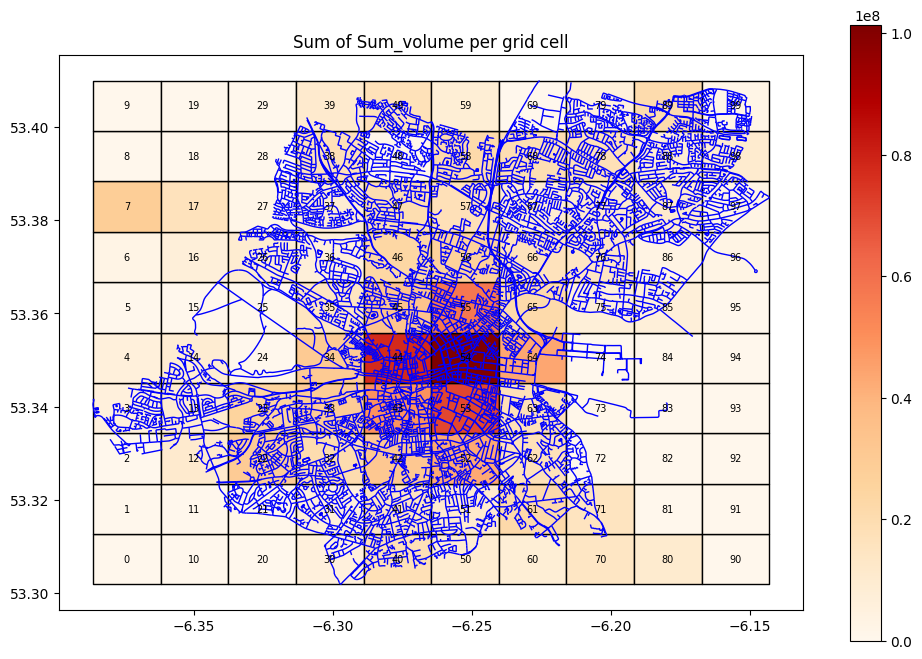

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
grid.plot(column='Sum_volume', ax=ax, cmap='OrRd', legend=True, edgecolor='k')
geo_edges.plot(ax=ax, color='blue', linewidth=1, label='Edges')

for idx, row in grid.iterrows():
    if row.geometry is not None and not row.geometry.is_empty:
        x, y = row.geometry.centroid.coords[0]
        ax.text(x, y, str(row.name), fontsize=7, color="black",
                ha="center", va="center")
        
plt.title("Sum of Sum_volume per grid cell")
plt.show()

In [9]:
joined_eval = joined.groupby(["Grid_ID","End_Time"]).agg({
    "Sum_Volume": "sum"
}).reset_index()
joined_eval = joined_eval.sort_values("Grid_ID")
joined_eval.head()

Grid_ID            End_Time  Sum_Volume
0      3.0 2024-07-01 00:00:00       843.0
1      3.0 2024-07-01 01:00:00       627.0
2      3.0 2024-07-01 02:00:00       340.0
3      3.0 2024-07-01 03:00:00       241.0
4      3.0 2024-07-01 04:00:00       183.0

In [10]:
may_eval = joined_may.groupby(["Grid_ID","End_Time"]).agg({
    "Sum_Volume": "sum"
}).reset_index()
may_eval = may_eval.sort_values("Grid_ID")
may_eval.head()

Grid_ID            End_Time  Sum_Volume
0      3.0 2025-05-01 00:00:00         626
1      3.0 2025-05-01 01:00:00         377
2      3.0 2025-05-01 02:00:00         200
3      3.0 2025-05-01 03:00:00         148
4      3.0 2025-05-01 04:00:00         127

In [11]:
may_eval["Vol_diff"] = may_eval["Sum_Volume"].diff().fillna(0)
may_eval['weekday'] = may_eval["End_Time"].dt.dayofweek
may_eval=may_eval[~may_eval["Grid_ID"].isin([72,73])]
may_eval.head()

Grid_ID            End_Time  Sum_Volume  Vol_diff  weekday
0      3.0 2025-05-01 00:00:00         626       0.0        3
1      3.0 2025-05-01 01:00:00         377    -249.0        3
2      3.0 2025-05-01 02:00:00         200    -177.0        3
3      3.0 2025-05-01 03:00:00         148     -52.0        3
4      3.0 2025-05-01 04:00:00         127     -21.0        3

In [12]:
may_weekdays = may_eval[may_eval["weekday"].isin(range(0,5))].copy()
may_saturdays = may_eval[may_eval["weekday"] == 5].copy()
may_sundays = may_eval[may_eval["weekday"] == 6].copy()

In [13]:
joined_eval["Vol_diff"] = joined_eval["Sum_Volume"].diff().fillna(0)
joined_eval['weekday'] = joined_eval["End_Time"].dt.dayofweek
joined_eval=joined_eval[~joined_eval["Grid_ID"].isin([72,73])]
joined_eval.head()

Grid_ID            End_Time  Sum_Volume  Vol_diff  weekday
0      3.0 2024-07-01 00:00:00       843.0       0.0        0
1      3.0 2024-07-01 01:00:00       627.0    -216.0        0
2      3.0 2024-07-01 02:00:00       340.0    -287.0        0
3      3.0 2024-07-01 03:00:00       241.0     -99.0        0
4      3.0 2024-07-01 04:00:00       183.0     -58.0        0

In [14]:
joined_eval.columns

Index(['Grid_ID', 'End_Time', 'Sum_Volume', 'Vol_diff', 'weekday'], dtype='object')

In [15]:
weekdays = joined_eval[joined_eval["weekday"].isin(range(0,5))].copy()
saturdays = joined_eval[joined_eval["weekday"] == 5].copy()
sundays = joined_eval[joined_eval["weekday"] == 6].copy()

In [16]:
grid_id=54
df_weekdays = weekdays[weekdays["Grid_ID"] == grid_id].copy()
df_sat = saturdays[saturdays["Grid_ID"] == grid_id].copy()
df_sun = sundays[sundays["Grid_ID"] == grid_id].copy()

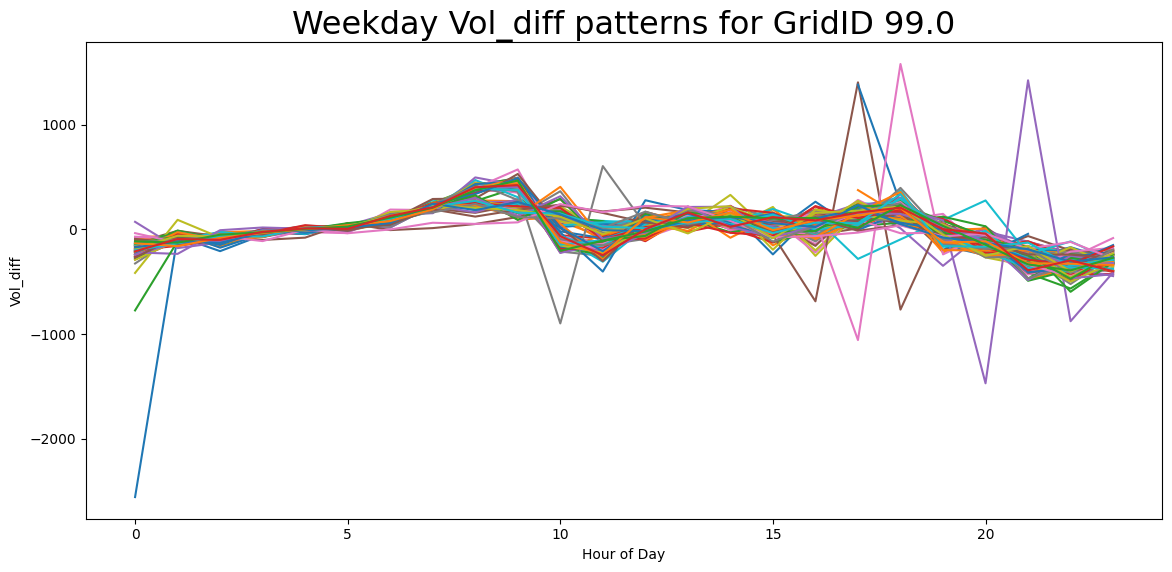

In [151]:

df_weekdays['date'] = df_weekdays['End_Time'].dt.date
df_weekdays['hour'] = df_weekdays['End_Time'].dt.hour  # or use End_Time directly if hourly

# Plot each day on the same graph
plt.figure(figsize=(12,6))
for date, group in df_weekdays.groupby('date'):
    plt.plot(group['hour'], group['Vol_diff'], label=str(date))


plt.rcParams.update({'font.size': 16})

plt.rcParams["font.family"] = "Times New Roman"

plt.style.use('bmh')

plt.xlabel("Hour of Day")
plt.ylabel("Vol_diff")
plt.title(f"Weekday Vol_diff patterns for GridID {grid_id}")
#plt.legend(title="Date", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [18]:

integrals = {}

for date, group in df_weekdays.groupby('date'):
    # Make sure values are sorted in time
    group = group.sort_values('End_Time')
    
    # x = time in hours since start of the day
    x = (group['End_Time'] - group['End_Time'].min()).dt.total_seconds() / 3600
    y = group['Vol_diff'].values
    
    # Trapezoidal integration
    integral = np.trapz(y, x)
    integrals[date] = integral

# Convert to DataFrame
daily_integrals = pd.DataFrame(list(integrals.items()), columns=['date', 'integral'])
print(daily_integrals)


          date  integral
0   2024-07-01      27.5
1   2024-07-02    5299.0
2   2024-07-03    6813.0
3   2024-07-04    3125.5
4   2024-07-05    4030.5
..         ...       ...
89  2025-04-24    8230.5
90  2025-04-25    4634.5
91  2025-04-28    3147.0
92  2025-04-29    4016.5
93  2025-04-30    3563.0

[94 rows x 2 columns]


C:\Users\smurph61\AppData\Local\Temp\ipykernel_4080\3977370359.py:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral = np.trapz(y, x)


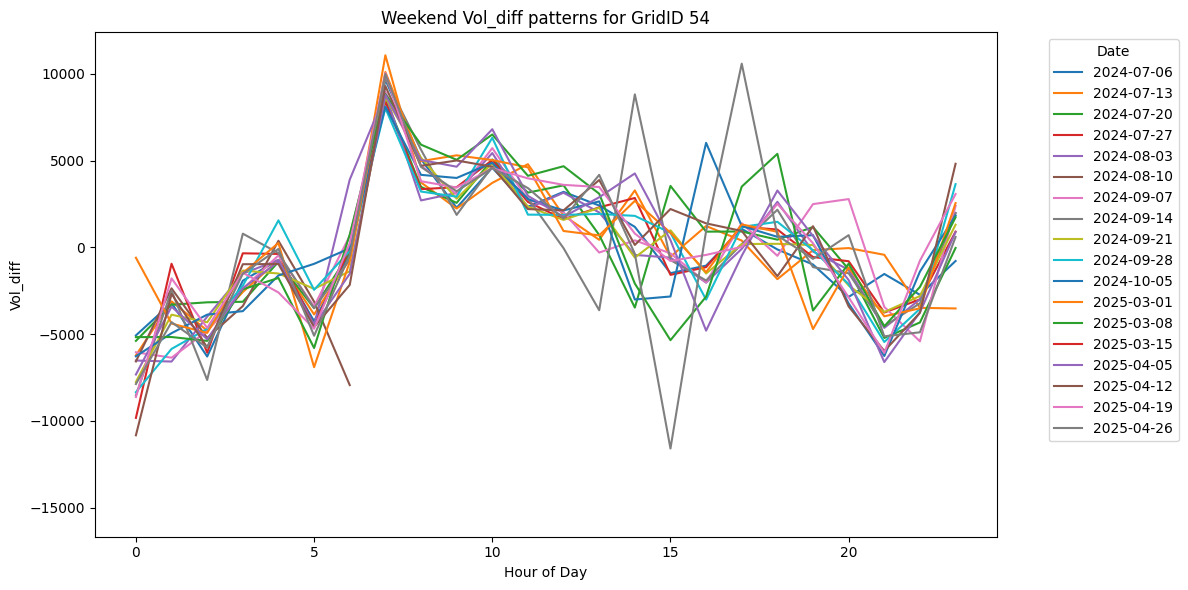

In [19]:

df_sat['date'] = df_sat['End_Time'].dt.date
df_sat['hour'] = df_sat['End_Time'].dt.hour  # or use End_Time directly if hourly

# Plot each day on the same graph
plt.figure(figsize=(12,6))
for date, group in df_sat.groupby('date'):
    plt.plot(group['hour'], group['Vol_diff'], label=str(date))

plt.xlabel("Hour of Day")
plt.ylabel("Vol_diff")
plt.title(f"Weekend Vol_diff patterns for GridID {grid_id}")
plt.legend(title="Date", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [20]:
integrals_sat = {}

for date, group in df_sat.groupby('date'):
    # Make sure values are sorted in time
    group = group.sort_values('End_Time')
    
    # x = time in hours since start of the day
    x = (group['End_Time'] - group['End_Time'].min()).dt.total_seconds() / 3600
    y = group['Vol_diff'].values
    
    # Trapezoidal integration
    integral = np.trapz(y, x)
    integrals_sat[date] = integral

# Convert to DataFrame
daily_integrals_sat = pd.DataFrame(list(integrals_sat.items()), columns=['date', 'integral'])
print(daily_integrals_sat)

          date  integral
0   2024-07-06    1425.5
1   2024-07-13    5696.0
2   2024-07-20    2968.5
3   2024-07-27    4352.0
4   2024-08-03    2228.0
5   2024-08-10  -20962.0
6   2024-09-07    3796.5
7   2024-09-14    2079.5
8   2024-09-21     395.0
9   2024-09-28    1044.5
10  2024-10-05    3282.5
11  2025-03-01    5378.5
12  2025-03-08    3947.0
13  2025-03-15       0.0
14  2025-04-05    2919.5
15  2025-04-12    2883.0
16  2025-04-19    7887.0
17  2025-04-26    1137.0


C:\Users\smurph61\AppData\Local\Temp\ipykernel_4080\1937423952.py:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral = np.trapz(y, x)


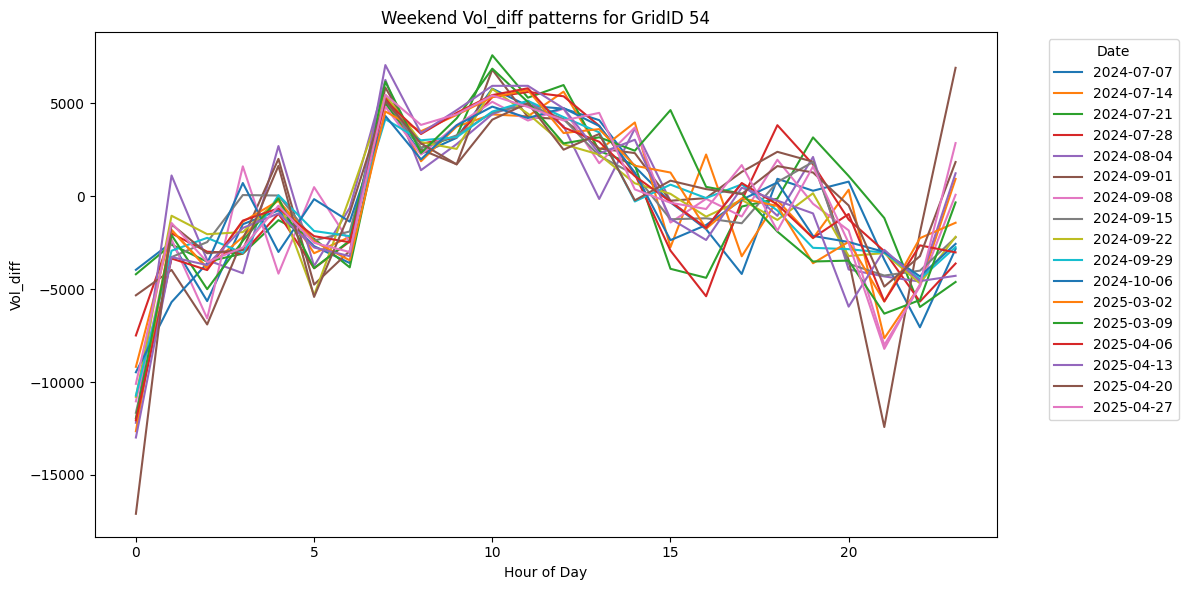

In [21]:

df_sun['date'] = df_sun['End_Time'].dt.date
df_sun['hour'] = df_sun['End_Time'].dt.hour  # or use End_Time directly if hourly

# Plot each day on the same graph
plt.figure(figsize=(12,6))
for date, group in df_sun.groupby('date'):
    plt.plot(group['hour'], group['Vol_diff'], label=str(date))

plt.xlabel("Hour of Day")
plt.ylabel("Vol_diff")
plt.title(f"Weekend Vol_diff patterns for GridID {grid_id}")
plt.legend(title="Date", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [22]:
integrals_sun = {}

for date, group in df_sun.groupby('date'):
    # Make sure values are sorted in time
    group = group.sort_values('End_Time')
    
    # x = time in hours since start of the day
    x = (group['End_Time'] - group['End_Time'].min()).dt.total_seconds() / 3600
    y = group['Vol_diff'].values
    
    # Trapezoidal integration
    integral = np.trapz(y, x)
    integrals_sun[date] = integral

# Convert to DataFrame
daily_integrals_sun = pd.DataFrame(list(integrals_sun.items()), columns=['date', 'integral'])
print(daily_integrals_sun)

          date  integral
0   2024-07-07   -3157.0
1   2024-07-14   -3773.5
2   2024-07-21    1045.0
3   2024-07-28   -1007.5
4   2024-08-04     697.0
5   2024-09-01    -354.5
6   2024-09-08   -4363.0
7   2024-09-15   -1983.5
8   2024-09-22   -3331.0
9   2024-09-29   -4089.5
10  2024-10-06   -5334.0
11  2025-03-02   -3072.5
12  2025-03-09   -4308.5
13  2025-04-06   -2588.0
14  2025-04-13   -4722.5
15  2025-04-20     468.0
16  2025-04-27     519.5


C:\Users\smurph61\AppData\Local\Temp\ipykernel_4080\1795947066.py:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral = np.trapz(y, x)


In [80]:
def fit_fourier(df, n_harmonics, Alpha):
    """
    Fit Fourier series to Vol_diff as a function of hour-of-day.
    Returns model and dataframe with fitted curve.
    """
    # Ensure datetime
    df['End_Time'] = pd.to_datetime(df['End_Time'])
    df['hour'] = df['End_Time'].dt.hour
    
    # Collapse by average per hour (so all days align)
    hourly = df.groupby('hour')['Vol_diff'].mean().reset_index()
    X = []
    
    for k in range(1, n_harmonics+1):
        hourly[f'sin{k}'] = np.sin(2*np.pi*k*hourly['hour']/24)
        hourly[f'cos{k}'] = np.cos(2*np.pi*k*hourly['hour']/24)
        X.append(hourly[[f'sin{k}', f'cos{k}']])
    
    X = pd.concat(X, axis=1)
    
    # Fit regression
    model = Ridge(alpha=Alpha) #LinearRegression()
    model.fit(X, hourly['Vol_diff'])
    
    # Predict smooth curve
    hours = np.linspace(0, 23, 200)
    X_pred = []
    for k in range(1, n_harmonics+1):
        X_pred.append(pd.DataFrame({
            f'sin{k}': np.sin(2*np.pi*k*hours/24),
            f'cos{k}': np.cos(2*np.pi*k*hours/24)
        }))
    X_pred = pd.concat(X_pred, axis=1)
    y_pred = model.predict(X_pred)
    
    return hourly, hours, y_pred, model

In [ ]:
# def fit_fourier(df, n_harmonics):
#     """
#     Fit Fourier series to Vol_diff as a function of hour-of-day.
#     Returns model and dataframe with fitted curve.
#     """
#     from sklearn.linear_model import RidgeCV  # <-- import here or at top of file

#     # Ensure datetime
#     df['End_Time'] = pd.to_datetime(df['End_Time'])
#     df['hour'] = df['End_Time'].dt.hour
    
#     # Collapse by average per hour (so all days align)
#     hourly = df.groupby('hour')['Vol_diff'].mean().reset_index()
#     X = []
    
#     # Build Fourier features
#     for k in range(1, n_harmonics+1):
#         hourly[f'sin{k}'] = np.sin(2*np.pi*k*hourly['hour']/24)
#         hourly[f'cos{k}'] = np.cos(2*np.pi*k*hourly['hour']/24)
#         X.append(hourly[[f'sin{k}', f'cos{k}']])
    
#     X = pd.concat(X, axis=1)

#     # === HERE is the replacement ===
#     alphas = np.logspace(-3, 3, 20)  # test alpha from 0.001 to 1000
#     model = RidgeCV(alphas=alphas, cv = 5)
#     model.fit(X, hourly['Vol_diff'])
#     print("Best alpha chosen:", model.alpha_)
#     # ===============================

#     # Predict smooth curve
#     hours = np.linspace(0, 23, 200)
#     X_pred = []
#     for k in range(1, n_harmonics+1):
#         X_pred.append(pd.DataFrame({
#             f'sin{k}': np.sin(2*np.pi*k*hours/24),
#             f'cos{k}': np.cos(2*np.pi*k*hours/24)
#         }))
#     X_pred = pd.concat(X_pred, axis=1)
#     y_pred = model.predict(X_pred)
    
#     return hourly, hours, y_pred, model

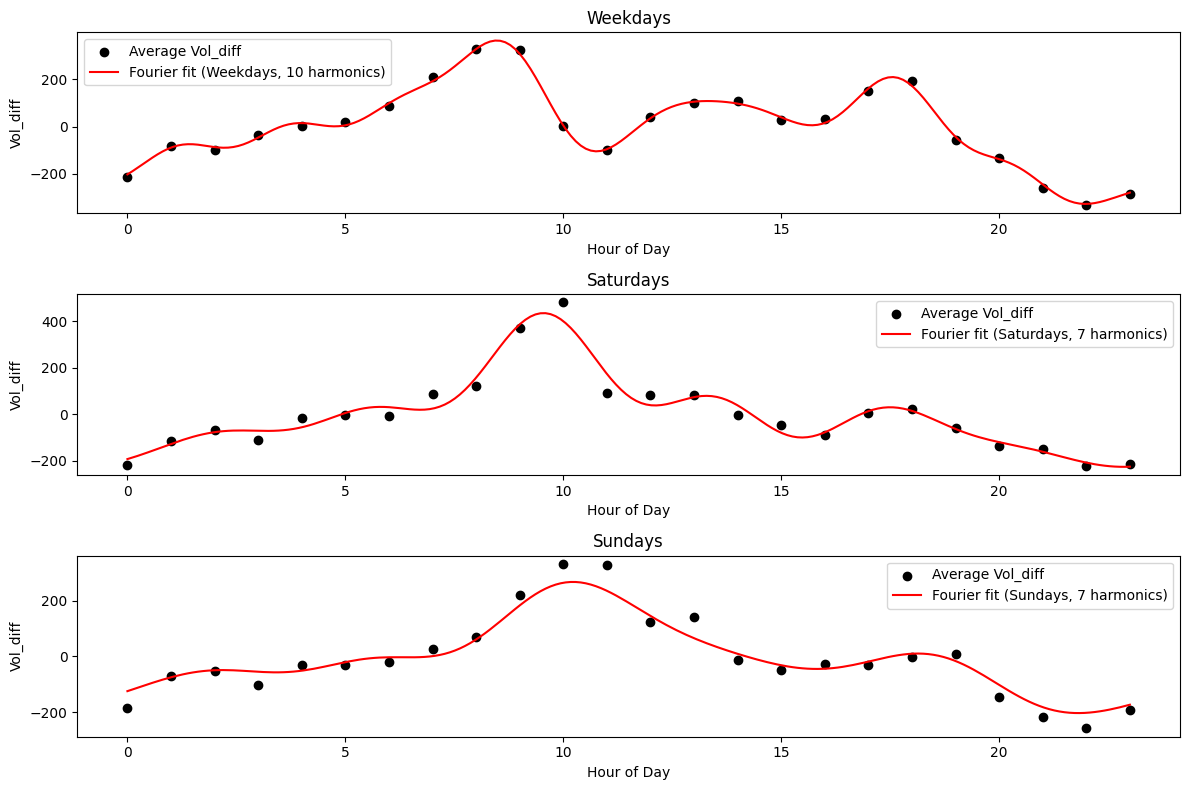

In [83]:
# Store results here
results = {}

groups = {
    "Weekdays": df_weekdays,
    "Saturdays": df_sat,
    "Sundays": df_sun
}

# Define harmonics per group
harmonics_map = {
    "Weekdays": 10,
    "Saturdays": 7,
    "Sundays": 7
}

alpha_map = {
    "Weekdays" : 0.3359818286283781,
    "Saturdays" : 0.1623776739188721,
    "Sundays" : 2.976351441631316

}
plt.figure(figsize=(12, 8))

for i, (label, df) in enumerate(groups.items(), 1):
    n_harmonics = harmonics_map[label]   # choose harmonics by group
    alpha = alpha_map[label]
    hourly, hours, y_pred, model = fit_fourier(df, n_harmonics, alpha)

    # Save results
    results[label] = {
        "hourly": hourly,
        "hours": hours,
        "y_pred": y_pred,
        "model": model,
        "n_harmonics": n_harmonics
    }

    # Plot
    plt.subplot(3, 1, i)
    plt.scatter(hourly['hour'], hourly['Vol_diff'], label="Average Vol_diff", color="black")
    plt.plot(hours, y_pred, label=f"Fourier fit ({label}, {n_harmonics} harmonics)", color="red")
    plt.title(label)
    plt.xlabel("Hour of Day")
    plt.ylabel("Vol_diff")
    plt.legend()

plt.tight_layout()
plt.show()

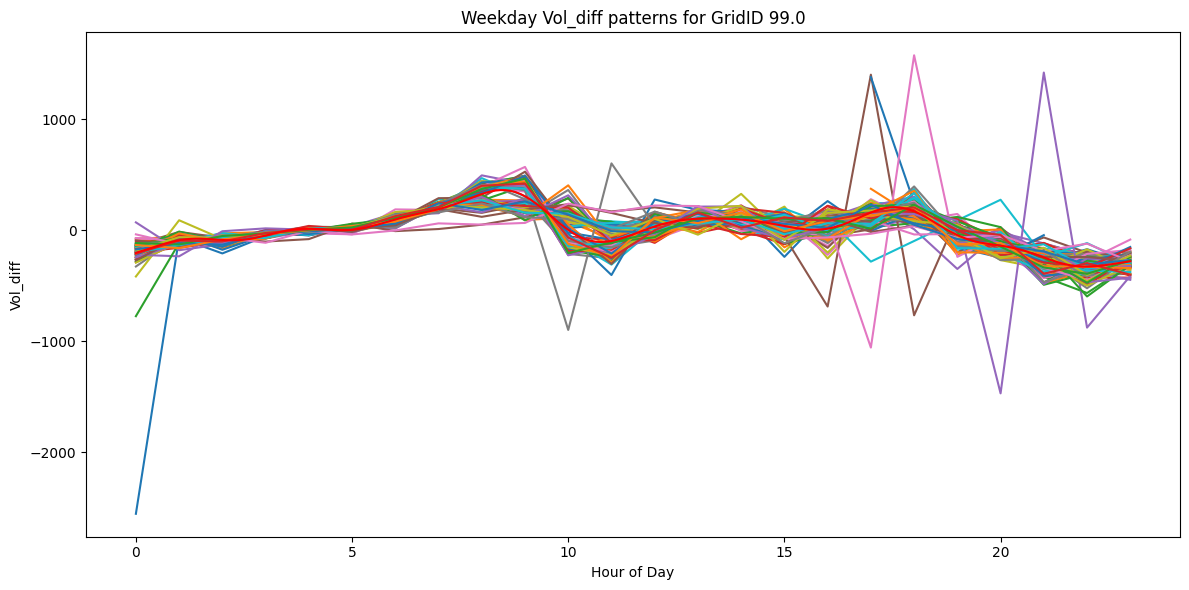

In [84]:
df_weekdays['date'] = df_weekdays['End_Time'].dt.date
df_weekdays['hour'] = df_weekdays['End_Time'].dt.hour  # or use End_Time directly if hourly

# Plot each day on the same graph
plt.figure(figsize=(12,6))
for date, group in df_weekdays.groupby('date'):
    plt.plot(group['hour'], group['Vol_diff'], label=str(date))

plt.plot(results['Weekdays']['hours'], results['Weekdays']['y_pred'], label=f"Fourier fit ({label})", color="red")

plt.xlabel("Hour of Day")
plt.ylabel("Vol_diff")
plt.title(f"Weekday Vol_diff patterns for GridID {grid_id}")
#plt.legend(title="Date", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
#edit

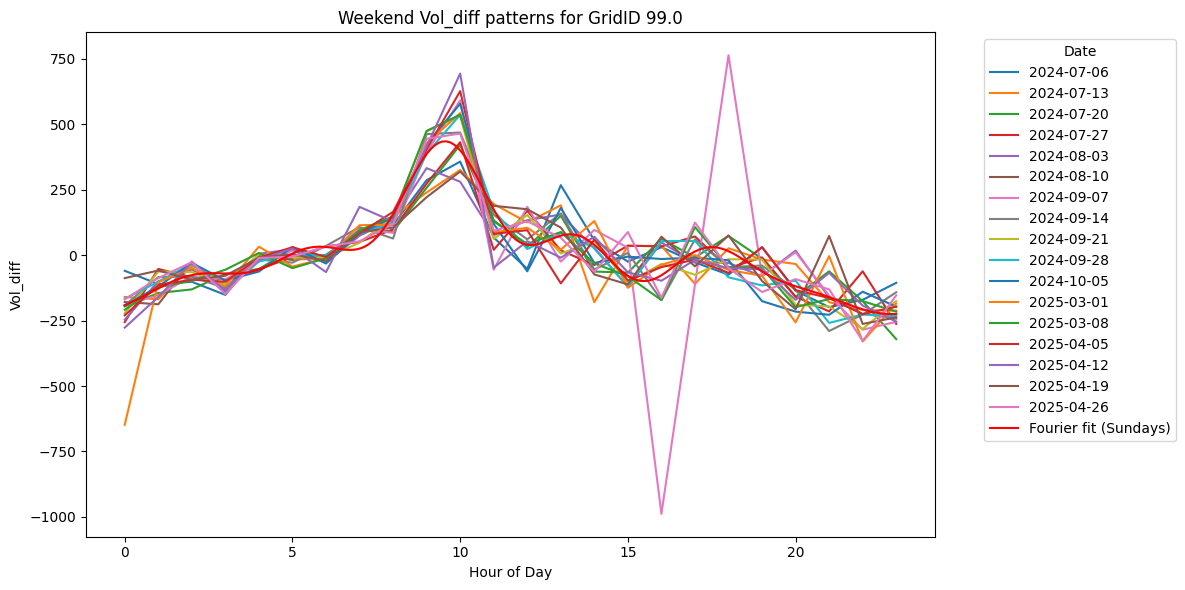

In [85]:
df_sat['date'] = df_sat['End_Time'].dt.date
df_sat['hour'] = df_sat['End_Time'].dt.hour  # or use End_Time directly if hourly

# Plot each day on the same graph
plt.figure(figsize=(12,6))
for date, group in df_sat.groupby('date'):
    plt.plot(group['hour'], group['Vol_diff'], label=str(date))

plt.plot(results['Saturdays']['hours'], results['Saturdays']['y_pred'], label=f"Fourier fit ({label})", color="red")

plt.xlabel("Hour of Day")
plt.ylabel("Vol_diff")
plt.title(f"Weekend Vol_diff patterns for GridID {grid_id}")
plt.legend(title="Date", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

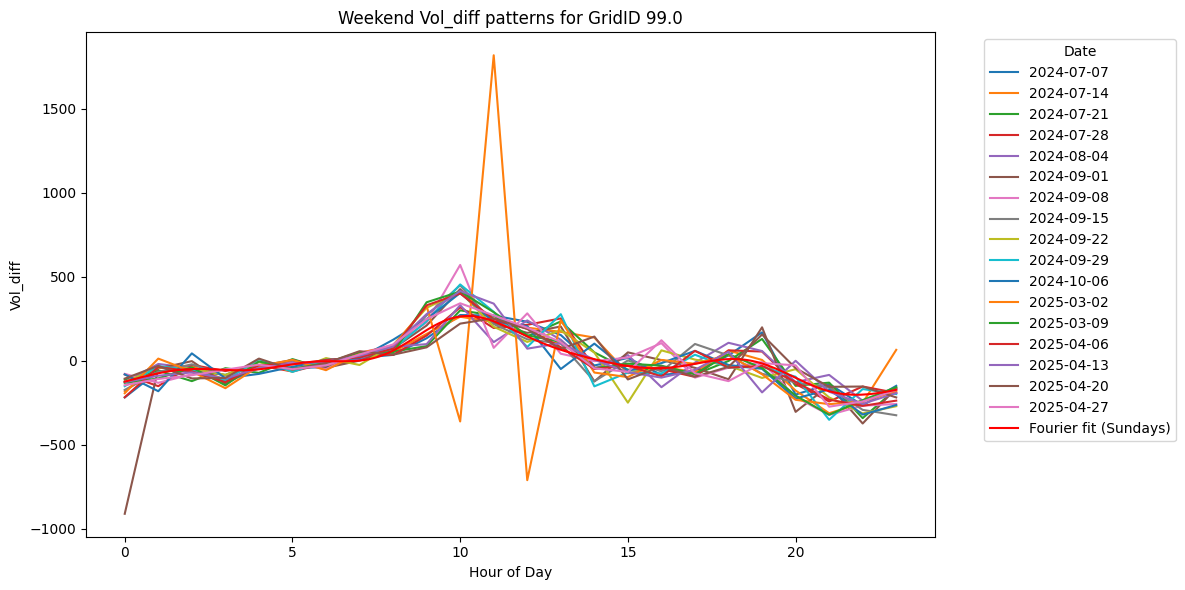

In [86]:

df_sun['date'] = df_sun['End_Time'].dt.date
df_sun['hour'] = df_sun['End_Time'].dt.hour  # or use End_Time directly if hourly

# Plot each day on the same graph
plt.figure(figsize=(12,6))
for date, group in df_sun.groupby('date'):
    plt.plot(group['hour'], group['Vol_diff'], label=str(date))

plt.plot(results['Sundays']['hours'], results['Sundays']['y_pred'], label=f"Fourier fit ({label})", color="red")

plt.xlabel("Hour of Day")
plt.ylabel("Vol_diff")
plt.title(f"Weekend Vol_diff patterns for GridID {grid_id}")
plt.legend(title="Date", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [88]:
# Dictionary to hold Fourier fit results
all_results = {}

# Collect mean reversion stats in a list
records = []

# Loop over every Grid_ID
for grid_id in joined_eval["Grid_ID"].unique():
    # Split this grid's data into weekdays, Saturday, Sunday
    df_weekdays = weekdays[weekdays["Grid_ID"] == grid_id].copy()
    df_sat = saturdays[saturdays["Grid_ID"] == grid_id].copy()
    df_sun = sundays[sundays["Grid_ID"] == grid_id].copy()

    # Skip if grid has no data at all
    if df_weekdays.empty and df_sat.empty and df_sun.empty:
        continue

    # Organize groups
    groups = {
        "Weekdays": df_weekdays,
        "Saturdays": df_sat,
        "Sundays": df_sun
    }

    # Choose harmonics per group
    harmonics_map = {
        "Weekdays": 14,
        "Saturdays": 10,
        "Sundays": 10
    }

    alpha_map = {
          "Weekdays" : 0.3359818286283781,
          "Saturdays" : 0.1623776739188721,
          "Sundays" : 2.976351441631316

        }

    grid_results = {}

    # Fit and save Fourier models for each group
    for label, df in groups.items():
        if df.empty:
            continue  # skip missing groups

        n_harmonics = harmonics_map[label]
        alpha = alpha_map[label]
        hourly, hours, y_pred, model = fit_fourier(df, n_harmonics, alpha)

        # Save fits in all_results
        grid_results[label] = {
            "hourly": hourly,
            "hours": hours,
            "y_pred": y_pred,
            "model": model,
            "n_harmonics": n_harmonics
        }


        # --- Mean reversion stats ---
        df = df.copy()
        df["hour"] = pd.to_datetime(df["End_Time"]).dt.hour

        # Build design matrix for raw df
        X = []
        for k in range(1, n_harmonics+1):
            X.append(pd.DataFrame({
                f'sin{k}': np.sin(2*np.pi*k*df['hour']/24),
                f'cos{k}': np.cos(2*np.pi*k*df['hour']/24)
            }))
        X = pd.concat(X, axis=1)

        df["fitted"] = model.predict(X)
        df["residuals"] = df["Vol_diff"] - df["fitted"]
        residuals = df["residuals"].values

        # ADF test
        try:
            adf_stat, p_val, *_ = adfuller(residuals)
        except Exception:
            adf_stat, p_val = None, None

        # AR(1) beta
        if len(residuals) > 1:
            r, r_next = residuals[:-1], residuals[1:]
            ar1_model = sm.OLS(r_next, sm.add_constant(r)).fit()
            beta = ar1_model.params[1]
        else:
            beta = None

        records.append({
            "Grid_ID": grid_id,
            "Group": label,
            "ADF_stat": adf_stat,
            "ADF_pval": p_val,
            "AR1_beta": beta
        })

    # Save all group results under this Grid_ID
    all_results[grid_id] = grid_results

# Convert mean reversion stats to dataframe
MeanReversionStats = pd.DataFrame(records)

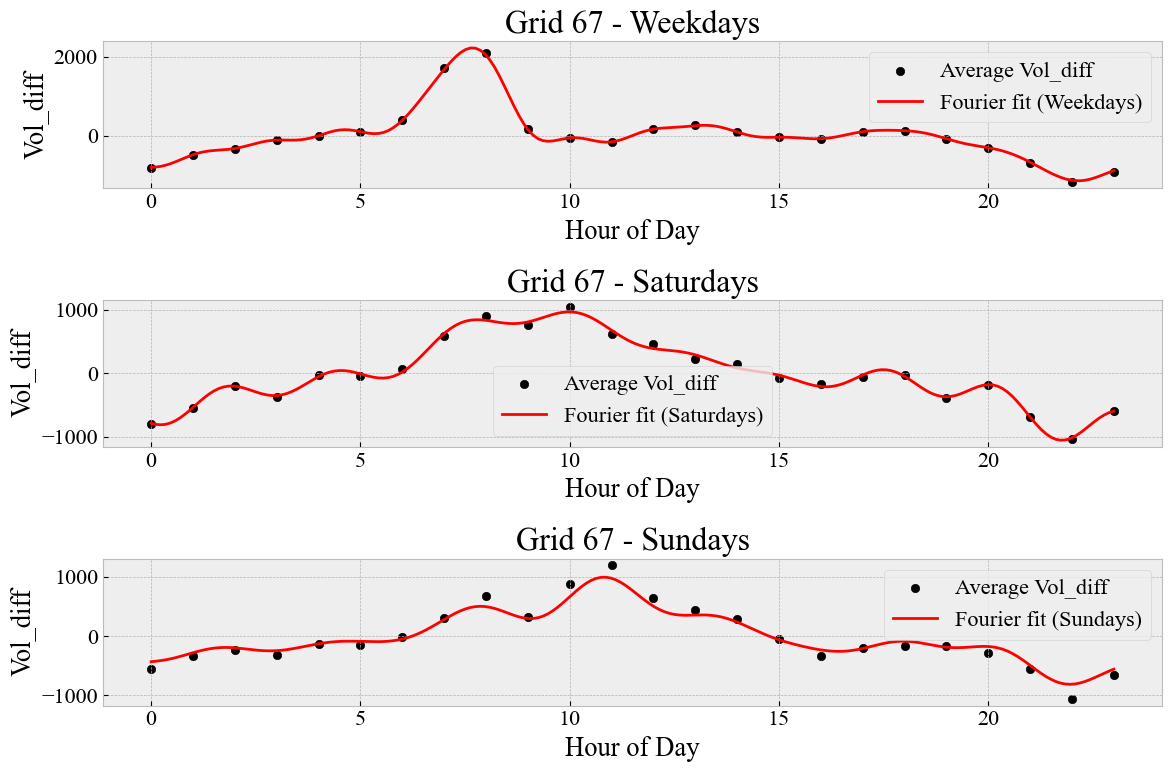

In [154]:

Grid = 67
groups = ["Weekdays", "Saturdays", "Sundays"]

plt.figure(figsize=(12, 8))  # bigger figure for 3 subplots

for i, label in enumerate(groups, 1):
    grid_data = all_results[Grid].get(label)
    if grid_data is None:
        continue  # skip if this group has no data

    hourly = grid_data["hourly"]
    hours = grid_data["hours"]
    y_pred = grid_data["y_pred"]

    plt.subplot(3, 1, i)
    plt.scatter(hourly['hour'], hourly['Vol_diff'], color="black", label="Average Vol_diff")
    plt.plot(hours, y_pred, color="red", label=f"Fourier fit ({label})")
    plt.title(f"Grid {Grid} - {label}")
    plt.xlabel("Hour of Day")
    plt.ylabel("Vol_diff")
    plt.legend()

plt.tight_layout()
plt.show()


In [90]:
records = []

# Loop through all results
for grid_id, grid_results in all_results.items():
    for label, res in grid_results.items():
        hours = res["hours"]
        y_pred = res["y_pred"]
        area = trapz(y_pred, hours)

        records.append({
            "Grid_ID": grid_id,
            "Group": label,
            "Integral": area
        })

# Convert to dataframe
Fit_Integrals = pd.DataFrame(records)

C:\Users\smurph61\AppData\Local\Temp\ipykernel_4080\1076102971.py:8: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = trapz(y_pred, hours)


In [91]:
Fit_Integrals

Grid_ID      Group    Integral
0        3.0   Weekdays  609.101732
1        3.0  Saturdays  185.052217
2        3.0    Sundays  -19.415508
3        4.0   Weekdays  650.070628
4        4.0  Saturdays  241.372821
..       ...        ...         ...
205     98.0  Saturdays  455.119631
206     98.0    Sundays  -18.547375
207     99.0   Weekdays  264.298974
208     99.0  Saturdays  121.637756
209     99.0    Sundays  -14.876929

[210 rows x 3 columns]

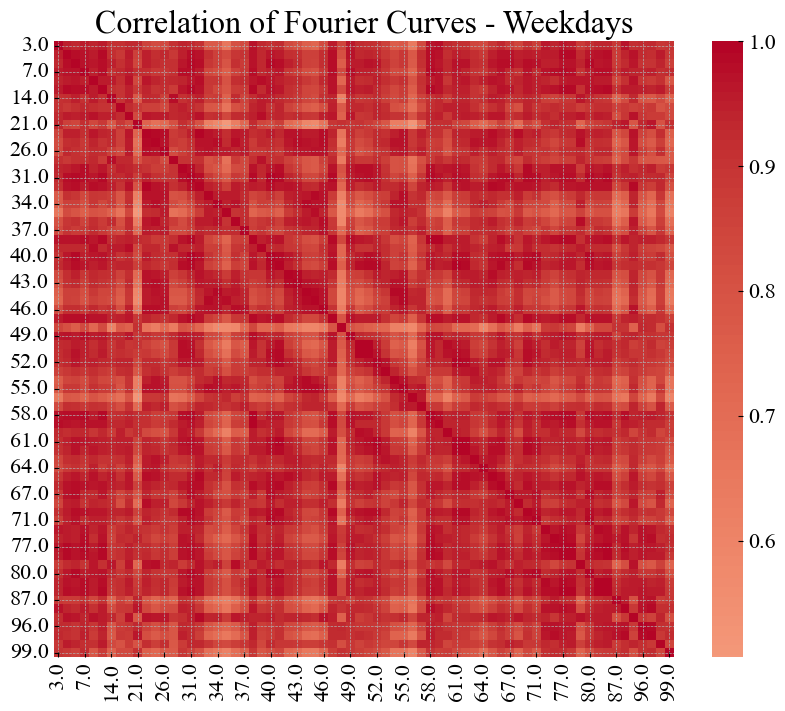

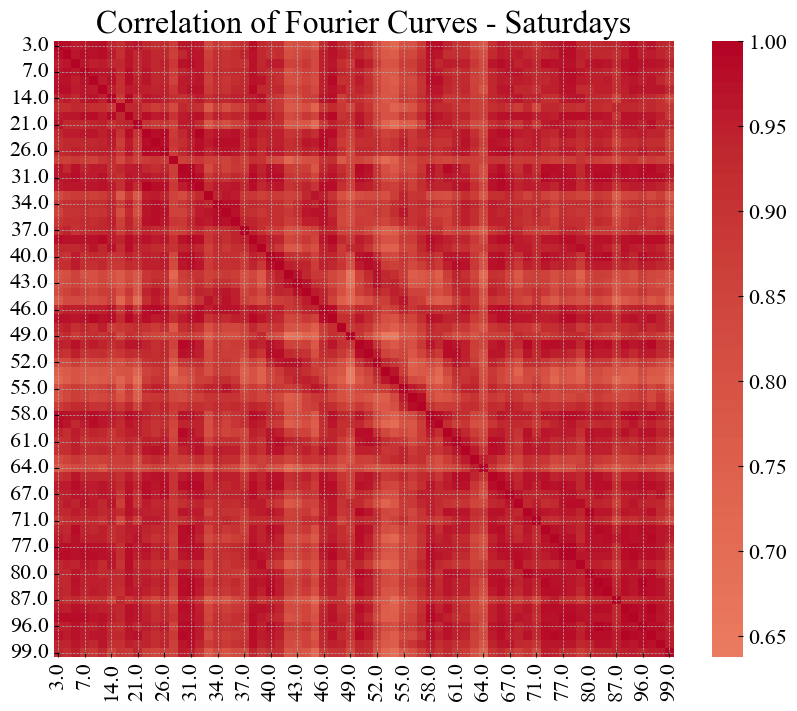

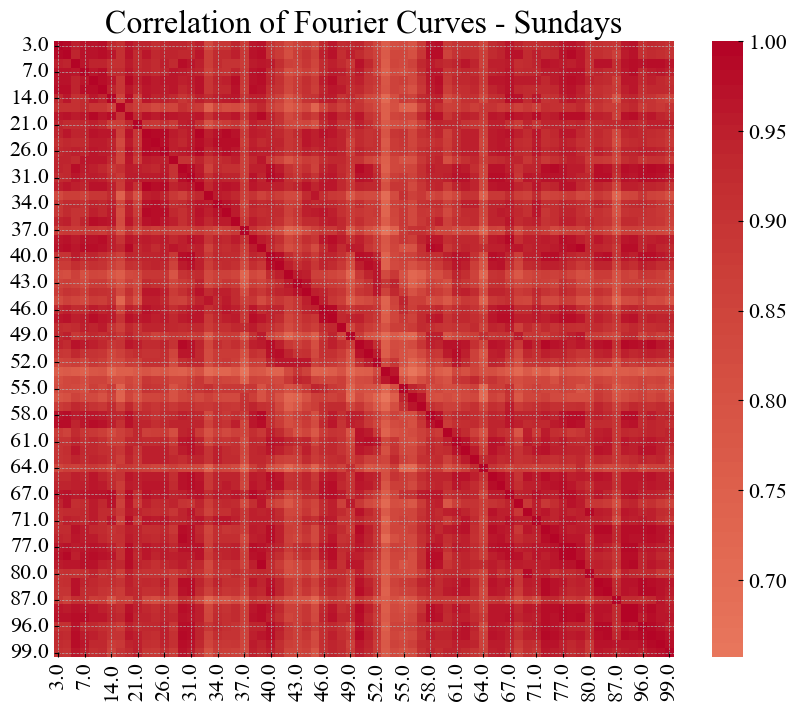

In [155]:
reference_hours = next(iter(next(iter(all_results.values())).values()))["hours"]

for group in ["Weekdays", "Saturdays", "Sundays"]:
    curves = {}

    # Collect fitted curves for each grid
    for grid_id, grid_results in all_results.items():
        if group in grid_results:
            res = grid_results[group]
            # y_pred should already be aligned with hours
            curves[grid_id] = res["y_pred"]

    # Build DataFrame: each column = grid_id, each row = predicted value at given hour
    df_curves = pd.DataFrame(curves, index=reference_hours)

    # Correlation across Grid_IDs
    corr = df_curves.corr()

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, cmap="coolwarm", center=0)
    plt.title(f"Correlation of Fourier Curves - {group}")
    plt.show()

In [93]:
MeanReversionStats

Grid_ID      Group   ADF_stat      ADF_pval  AR1_beta
0        3.0   Weekdays -12.222773  1.097659e-22  0.021057
1        3.0  Saturdays  -7.816605  6.843560e-12 -0.168873
2        3.0    Sundays  -9.454998  4.509932e-16 -0.038827
3        4.0   Weekdays -10.055961  1.372901e-17 -0.107041
4        4.0  Saturdays  -8.924378  1.020667e-14 -0.136443
..       ...        ...        ...           ...       ...
205     98.0  Saturdays -14.072804  2.920020e-26 -0.043256
206     98.0    Sundays  -9.306240  1.078881e-15 -0.180674
207     99.0   Weekdays -10.597662  6.288503e-19 -0.283029
208     99.0  Saturdays  -9.759791  7.617166e-17 -0.346297
209     99.0    Sundays  -9.565198  2.367362e-16 -0.429853

[210 rows x 5 columns]

In [94]:
print("ADF_pval summary:")
print(MeanReversionStats["ADF_pval"].describe())

print("\nAR1_beta summary:")
print(MeanReversionStats["AR1_beta"].describe())

ADF_pval summary:
count    2.100000e+02
mean     2.040201e-10
std      2.845327e-09
min      0.000000e+00
25%      3.144901e-22
50%      3.613766e-18
75%      2.544722e-15
max      4.122268e-08
Name: ADF_pval, dtype: float64

AR1_beta summary:
count    210.000000
mean      -0.162095
std        0.153513
min       -0.536487
25%       -0.278049
50%       -0.158358
75%       -0.060981
max        0.190672
Name: AR1_beta, dtype: float64


In [95]:
may_groups = {
    "Weekdays": may_weekdays,
    "Saturdays": may_saturdays,
    "Sundays": may_sundays
}

may_records = []

for grid_id, grid_results in all_results.items():
    for label, res in grid_results.items():
        # Grab May data for this group
        if label not in may_groups:
            continue
        df = may_groups[label]
        df = df[df["Grid_ID"] == grid_id].copy()
        if df.empty:
            continue

        n_harmonics = res["n_harmonics"]
        model = res["model"]

        # Build Fourier features for May data
        df["hour"] = pd.to_datetime(df["End_Time"]).dt.hour
        X_may = []
        for k in range(1, n_harmonics+1):
            X_may.append(pd.DataFrame({
                f'sin{k}': np.sin(2*np.pi*k*df['hour']/24),
                f'cos{k}': np.cos(2*np.pi*k*df['hour']/24)
            }))
        X_may = pd.concat(X_may, axis=1)

        # Predict
        df["fitted"] = model.predict(X_may)

        # Store metrics
        mse = mean_squared_error(df["Vol_diff"], df["fitted"])
        r2 = r2_score(df["Vol_diff"], df["fitted"])

        may_records.append({
            "Grid_ID": grid_id,
            "Group": label,
            "RMSE": np.sqrt(mse),
            "R2": r2
        })

MayFitStats = pd.DataFrame(may_records)


In [96]:
MayFitStats

Grid_ID      Group        RMSE        R2
0        3.0   Weekdays  222.681376  0.791313
1        3.0  Saturdays  150.693988  0.837238
2        3.0    Sundays  140.815234  0.796046
3        4.0   Weekdays  233.358748  0.715243
4        4.0  Saturdays  170.591749  0.751586
..       ...        ...         ...       ...
205     98.0  Saturdays  304.794586  0.801018
206     98.0    Sundays  272.102930  0.817953
207     99.0   Weekdays  118.188841  0.710064
208     99.0  Saturdays  156.088591  0.513068
209     99.0    Sundays   77.164531  0.786925

[210 rows x 4 columns]

In [97]:
print("=== May RMSE summary by Group ===")
print(MayFitStats.groupby("Group")["RMSE"].describe(), "\n")

print("=== May R2 summary by Group ===")
print(MayFitStats.groupby("Group")["R2"].describe())

=== May RMSE summary by Group ===
           count        mean         std        min         25%         50%  \
Group                                                                         
Saturdays   70.0  507.519217  430.195550  30.163225  218.101806  387.578688   
Sundays     70.0  446.096859  377.242659  27.020731  218.732150  324.249205   
Weekdays    70.0  555.342033  489.770686  82.328651  288.664317  420.844853   

                  75%          max  
Group                               
Saturdays  641.661400  1976.508018  
Sundays    536.200459  1755.277286  
Weekdays   635.620634  2884.751358   

=== May R2 summary by Group ===
           count      mean       std       min       25%       50%       75%  \
Group                                                                          
Saturdays   70.0  0.749426  0.145602  0.220636  0.672752  0.802692  0.854376   
Sundays     70.0  0.765214  0.132821  0.156800  0.763810  0.811585  0.839030   
Weekdays    70.0  0.809470  0.1

In [98]:
reversion_records = []

for grid_id, grid_results in all_results.items():
    for label, res in grid_results.items():
        # Grab May data for this group
        if label not in may_groups:
            continue
        df = may_groups[label]
        df = df[df["Grid_ID"] == grid_id].copy()
        if df.empty:
            continue

        n_harmonics = res["n_harmonics"]
        model = res["model"]

        # Build Fourier features for May data
        df["hour"] = pd.to_datetime(df["End_Time"]).dt.hour
        X_may = []
        for k in range(1, n_harmonics+1):
            X_may.append(pd.DataFrame({
                f'sin{k}': np.sin(2*np.pi*k*df['hour']/24),
                f'cos{k}': np.cos(2*np.pi*k*df['hour']/24)
            }))
        X_may = pd.concat(X_may, axis=1)

        # Residuals (May data vs old Fourier fit)
        df["fitted"] = model.predict(X_may)
        df["residuals"] = df["Vol_diff"] - df["fitted"]
        residuals = df["residuals"].values

        # --- Mean reversion tests ---
        try:
            adf_stat, p_value, *_ = adfuller(residuals)
        except Exception:
            adf_stat, p_value = None, None

        if len(residuals) > 1:
            r, r_next = residuals[:-1], residuals[1:]
            ar1_model = sm.OLS(r_next, sm.add_constant(r)).fit()
            beta = ar1_model.params[1]
        else:
            beta = None

        reversion_records.append({
            "Grid_ID": grid_id,
            "Group": label,
            "ADF_stat": adf_stat,
            "ADF_pval": p_value,
            "AR1_beta": beta
        })

# Collect results
MayMeanReversionStats = pd.DataFrame(reversion_records)

In [99]:
MayMeanReversionStats

Grid_ID      Group   ADF_stat      ADF_pval  AR1_beta
0        3.0   Weekdays  -8.782336  2.358217e-14  0.083578
1        3.0  Saturdays -11.072358  4.520199e-20 -0.030129
2        3.0    Sundays  -4.737041  7.165507e-05 -0.199588
3        4.0   Weekdays  -9.526066  2.975647e-16 -0.059946
4        4.0  Saturdays  -4.875213  3.896291e-05  0.189093
..       ...        ...        ...           ...       ...
205     98.0  Saturdays  -7.444530  5.885781e-11 -0.062832
206     98.0    Sundays  -7.788928  8.038891e-12  0.211466
207     99.0   Weekdays -10.796812  2.065488e-19 -0.090064
208     99.0  Saturdays -10.112573  9.914224e-18 -0.434200
209     99.0    Sundays  -5.057304  1.707197e-05 -0.154649

[210 rows x 5 columns]

In [100]:
print("ADF_pval summary:")
print(MayMeanReversionStats["ADF_pval"].describe())

print("\nAR1_beta summary:")
print(MayMeanReversionStats["AR1_beta"].describe())

ADF_pval summary:
count    2.100000e+02
mean     5.668145e-04
std      4.976615e-03
min      2.030473e-30
25%      4.360824e-19
50%      2.302479e-14
75%      3.558668e-07
max      7.011896e-02
Name: ADF_pval, dtype: float64

AR1_beta summary:
count    210.000000
mean      -0.119716
std        0.187748
min       -0.598932
25%       -0.253408
50%       -0.095833
75%        0.013757
max        0.261825
Name: AR1_beta, dtype: float64


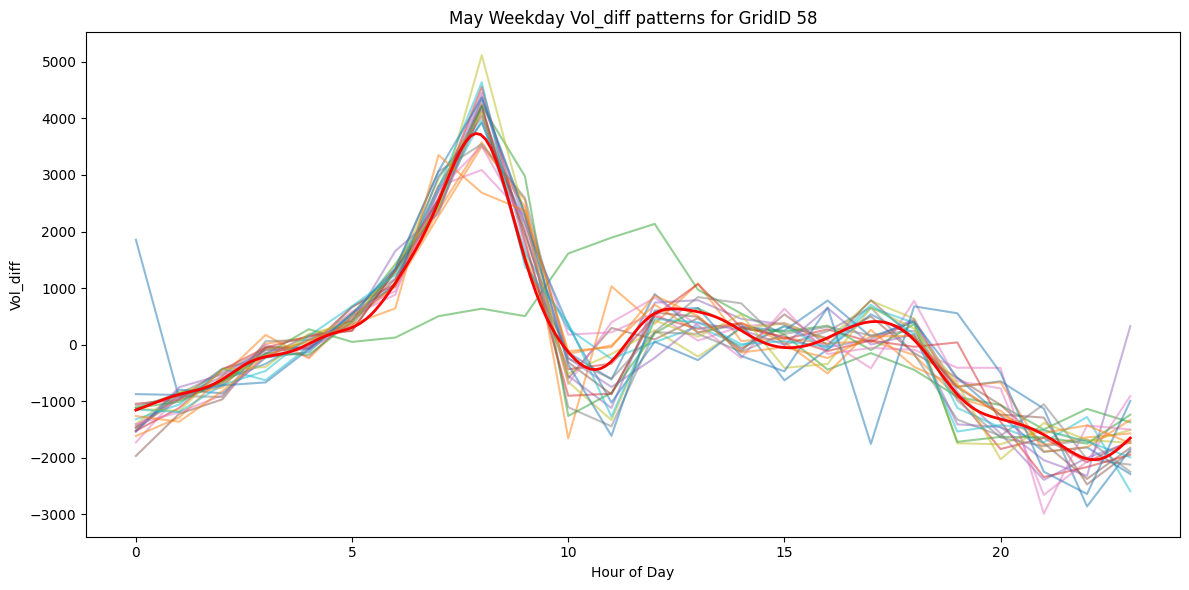

In [101]:
grid_id=58
label = "Weekdays"

# Get May weekday data for this grid
df_may_weekdays = may_weekdays[may_weekdays["Grid_ID"] == grid_id].copy()
df_may_weekdays["date"] = pd.to_datetime(df_may_weekdays["End_Time"]).dt.date
df_may_weekdays["hour"] = pd.to_datetime(df_may_weekdays["End_Time"]).dt.hour

plt.figure(figsize=(12,6))

# Plot each May weekday separately
for date, group in df_may_weekdays.groupby("date"):
    plt.plot(group["hour"], group["Vol_diff"], alpha=0.5, label=str(date))

# Overlay Fourier best fit from earlier training
res = all_results[grid_id][label]
plt.plot(res["hours"], res["y_pred"], color="red", linewidth=2, label="Fourier Fit (Weekdays)")

plt.xlabel("Hour of Day")
plt.ylabel("Vol_diff")
plt.title(f"May Weekday Vol_diff patterns for GridID {grid_id}")
# plt.legend(title="Date", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

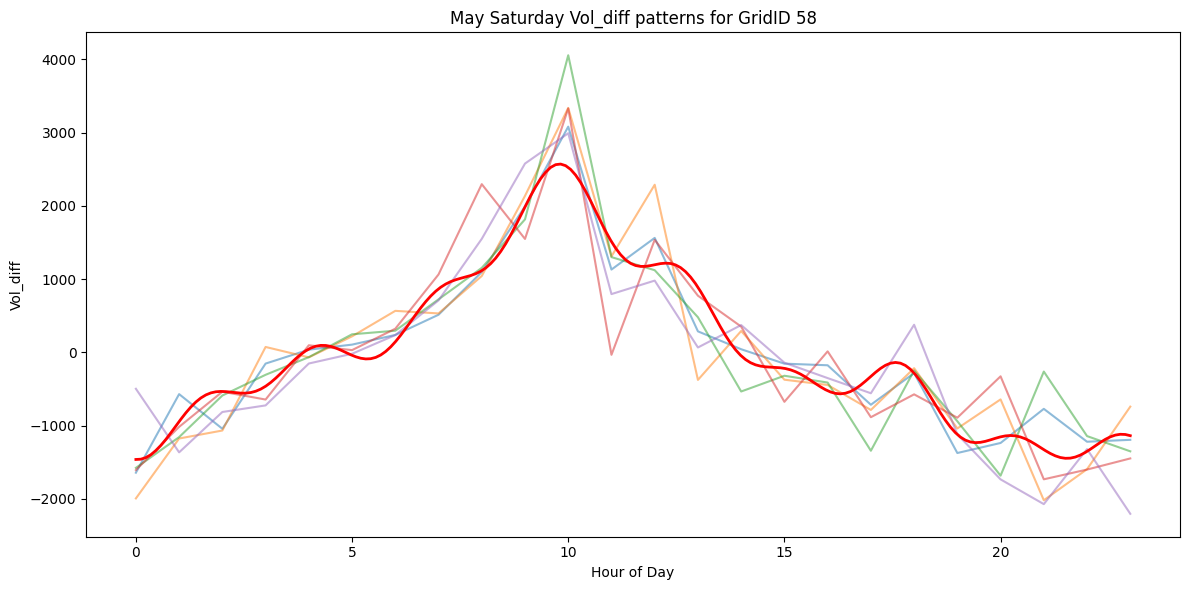

In [102]:
label = "Saturdays"

# Get May Saturday data for this grid
df_may_sat = may_saturdays[may_saturdays["Grid_ID"] == grid_id].copy()
df_may_sat["date"] = pd.to_datetime(df_may_sat["End_Time"]).dt.date
df_may_sat["hour"] = pd.to_datetime(df_may_sat["End_Time"]).dt.hour

plt.figure(figsize=(12,6))

# Plot each May Saturday separately
for date, group in df_may_sat.groupby("date"):
    plt.plot(group["hour"], group["Vol_diff"], alpha=0.5, label=str(date))

# Overlay Fourier best fit from earlier training
res = all_results[grid_id][label]
plt.plot(res["hours"], res["y_pred"], color="red", linewidth=2, label="Fourier Fit (Saturdays)")

plt.xlabel("Hour of Day")
plt.ylabel("Vol_diff")
plt.title(f"May Saturday Vol_diff patterns for GridID {grid_id}")
# plt.legend(title="Date", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

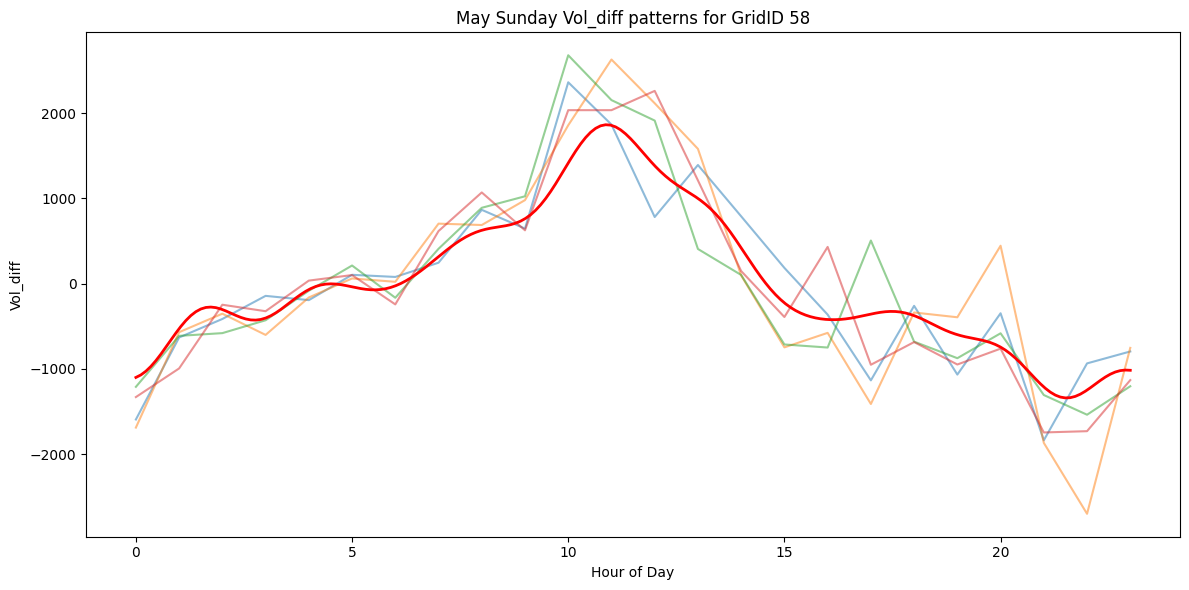

In [103]:
label = "Sundays"

# Get May Sunday data for this grid
df_may_sun = may_sundays[may_sundays["Grid_ID"] == grid_id].copy()
df_may_sun["date"] = pd.to_datetime(df_may_sun["End_Time"]).dt.date
df_may_sun["hour"] = pd.to_datetime(df_may_sun["End_Time"]).dt.hour

plt.figure(figsize=(12,6))

# Plot each May Sunday separately
for date, group in df_may_sun.groupby("date"):
    plt.plot(group["hour"], group["Vol_diff"], alpha=0.5, label=str(date))

# Overlay Fourier best fit from earlier training
res = all_results[grid_id][label]
plt.plot(res["hours"], res["y_pred"], color="red", linewidth=2, label="Fourier Fit (Sundays)")

plt.xlabel("Hour of Day")
plt.ylabel("Vol_diff")
plt.title(f"May Sunday Vol_diff patterns for GridID {grid_id}")
# plt.legend(title="Date", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [104]:
def forecast_with_mean_reversion(df, model, n_harmonics, cutoff_hour):
    df = df.copy()
    df["hour"] = pd.to_datetime(df["End_Time"]).dt.hour

    # Build Fourier features
    X_all = []
    for k in range(1, n_harmonics+1):
        X_all.append(pd.DataFrame({
            f'sin{k}': np.sin(2*np.pi*k*df['hour']/24),
            f'cos{k}': np.cos(2*np.pi*k*df['hour']/24)
        }))
    X_all = pd.concat(X_all, axis=1)

    df["fitted"] = model.predict(X_all)
    df["residuals"] = df["Vol_diff"] - df["fitted"]

    # Split early vs late
    df_early = df[df["hour"] <= cutoff_hour]
    df_late = df[df["hour"] > cutoff_hour]

    if df_early.empty or df_late.empty or len(df_early) < 2:
        return df_early, df_late, None, None   # <-- always 4 outputs

    # Fit AR(1) on early residuals
    r = df_early["residuals"].values
    r_lag, r_next = r[:-1], r[1:]
    ar1_model = sm.OLS(r_next, sm.add_constant(r_lag)).fit()

    # Forecast residual path for late hours
    last_resid = r[-1]
    forecast_resids = []
    for _ in range(len(df_late)):
        last_resid = ar1_model.params[0] + ar1_model.params[1]*last_resid
        forecast_resids.append(last_resid)

    df_late["adjusted_pred"] = df_late["fitted"].values + np.array(forecast_resids)

    # Metrics for late part only
    rmse = np.sqrt(mean_squared_error(df_late["Vol_diff"], df_late["adjusted_pred"]))
    r2 = r2_score(df_late["Vol_diff"], df_late["adjusted_pred"])

    return df_early, df_late, rmse, r2 


In [105]:
comp_records = []
may_groups = {
    "Weekdays": may_weekdays,
    "Saturdays": may_saturdays,
    "Sundays": may_sundays
}

for grid_id, grid_results in all_results.items():
    for label, res in grid_results.items():
        if label not in may_groups:
            continue
        df = may_groups[label]
        df = df[df["Grid_ID"] == grid_id].copy()
        if df.empty:
            continue

        _, _, rmse, r2 = forecast_with_mean_reversion(
            df=df,
            model=res["model"],
            n_harmonics=res["n_harmonics"],
            cutoff_hour=12   # can change cutoff
        )

        if rmse is not None:
            comp_records.append({
                "Grid_ID": grid_id,
                "Group": label,
                "CutoffHour": 12,
                "RMSE": rmse,
                "R2": r2
            })

MayMeanReversionFitStats = pd.DataFrame(comp_records)

C:\Users\smurph61\AppData\Local\Temp\ipykernel_4080\2912442766.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_late["adjusted_pred"] = df_late["fitted"].values + np.array(forecast_resids)
C:\Users\smurph61\AppData\Local\Temp\ipykernel_4080\2912442766.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_late["adjusted_pred"] = df_late["fitted"].values + np.array(forecast_resids)
C:\Users\smurph61\AppData\Local\Temp\ipykernel_4080\2912442766.py:36: SettingWithCopyWarning: 
A value is trying to be s

In [106]:
MayMeanReversionFitStats

Grid_ID      Group  CutoffHour        RMSE        R2
0        3.0   Weekdays          12  267.338626  0.642384
1        3.0  Saturdays          12  175.681604  0.333739
2        3.0    Sundays          12  185.506589  0.484640
3        4.0   Weekdays          12  267.077912  0.372666
4        4.0  Saturdays          12  210.483739  0.075181
..       ...        ...         ...         ...       ...
205     98.0  Saturdays          12  374.954060  0.347683
206     98.0    Sundays          12  296.450806  0.553235
207     99.0   Weekdays          12  118.661694  0.681473
208     99.0  Saturdays          12  107.758176  0.369723
209     99.0    Sundays          12   86.334405  0.566276

[210 rows x 5 columns]

In [107]:
print("=== May RMSE summary by Group ===")
print(MayMeanReversionFitStats.groupby("Group")["RMSE"].describe(), "\n")

print("=== May R2 summary by Group ===")
print(MayMeanReversionFitStats.groupby("Group")["R2"].describe())

=== May RMSE summary by Group ===
           count        mean         std        min         25%         50%  \
Group                                                                         
Saturdays   70.0  544.283354  456.415201  34.207030  260.351884  445.318613   
Sundays     70.0  478.261924  412.277525  33.348719  239.342639  360.917486   
Weekdays    70.0  562.489245  566.822721  53.924694  267.679797  395.451712   

                  75%          max  
Group                               
Saturdays  668.312779  2414.056192  
Sundays    617.881959  2330.952984  
Weekdays   584.551111  3497.311238   

=== May R2 summary by Group ===
           count      mean       std       min       25%       50%       75%  \
Group                                                                          
Saturdays   70.0  0.442145  0.166486  0.075181  0.348494  0.466898  0.538620   
Sundays     70.0  0.597277  0.154249  0.046625  0.556873  0.627615  0.688689   
Weekdays    70.0  0.631772  0.1

In [108]:
joined_eval.head()

Grid_ID            End_Time  Sum_Volume  Vol_diff  weekday  hour     Group  \
0      3.0 2024-07-01 00:00:00       843.0       0.0        0     0  Weekdays   
1      3.0 2024-07-01 01:00:00       627.0    -216.0        0     1  Weekdays   
2      3.0 2024-07-01 02:00:00       340.0    -287.0        0     2  Weekdays   
3      3.0 2024-07-01 03:00:00       241.0     -99.0        0     3  Weekdays   
4      3.0 2024-07-01 04:00:00       183.0     -58.0        0     4  Weekdays   

       y_pred   pred_diff        date  cumsum_pred_diff    new_pred  \
0 -369.989130  369.989130  2024-07-01        369.989130 -384.788696   
1 -201.564379  -14.435621  2024-07-01        355.553509 -216.379108   
2 -153.265370 -133.734630  2024-07-01        221.818879 -162.909669   
3  -75.539238  -23.460762  2024-07-01        198.358117  -84.555516   
4   -3.129721  -54.870279  2024-07-01        143.487838   -9.962475   

   new_pred_diff  
0     384.788696  
1       0.379108  
2    -124.090331  
3     -14.444484  
4     -48.037525

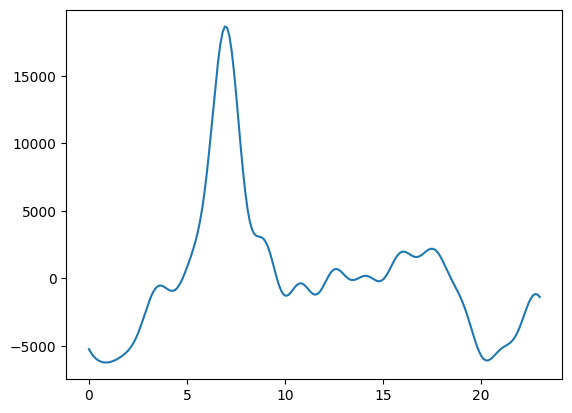

In [109]:
all_results[54]["Weekdays"]["y_pred"]
plt.plot(all_results[54]["Weekdays"]["hours"], all_results[54]["Weekdays"]["y_pred"] )

In [110]:
joined_eval["hour"] = pd.to_datetime(joined_eval["End_Time"]).dt.hour
joined_eval["Group"] = np.where(joined_eval["weekday"].isin(range(0,5)), "Weekdays",
                        np.where(joined_eval["weekday"] == 5, "Saturdays", "Sundays"))

In [111]:
joined_eval.head()

Grid_ID            End_Time  Sum_Volume  Vol_diff  weekday  hour     Group  \
0      3.0 2024-07-01 00:00:00       843.0       0.0        0     0  Weekdays   
1      3.0 2024-07-01 01:00:00       627.0    -216.0        0     1  Weekdays   
2      3.0 2024-07-01 02:00:00       340.0    -287.0        0     2  Weekdays   
3      3.0 2024-07-01 03:00:00       241.0     -99.0        0     3  Weekdays   
4      3.0 2024-07-01 04:00:00       183.0     -58.0        0     4  Weekdays   

       y_pred   pred_diff        date  cumsum_pred_diff    new_pred  \
0 -369.989130  369.989130  2024-07-01        369.989130 -384.788696   
1 -201.564379  -14.435621  2024-07-01        355.553509 -216.379108   
2 -153.265370 -133.734630  2024-07-01        221.818879 -162.909669   
3  -75.539238  -23.460762  2024-07-01        198.358117  -84.555516   
4   -3.129721  -54.870279  2024-07-01        143.487838   -9.962475   

   new_pred_diff  
0     384.788696  
1       0.379108  
2    -124.090331  
3     -14.444484  
4     -48.037525

In [112]:
may_eval["hour"] = pd.to_datetime(may_eval["End_Time"]).dt.hour
may_eval["Group"] = np.where(may_eval["weekday"].isin(range(0,5)), "Weekdays",
                        np.where(may_eval["weekday"] == 5, "Saturdays", "Sundays")) 

In [113]:
joined_eval["y_pred"] = np.nan  # placeholder

for grid_id, grid_results in all_results.items():
    for group, res in grid_results.items():
        hours_fit = res["hours"]        # smooth grid (200 points between 0–23)
        y_fit = res["y_pred"]           # Fourier fit values

        # Interpolate onto discrete hours 0–23
        for hour in range(24):
            pred_val = interp(hour, hours_fit, y_fit)

            mask = (
                (joined_eval["Grid_ID"] == grid_id) &
                (joined_eval["Group"] == group) &
                (joined_eval["hour"] == hour)
            )
            joined_eval.loc[mask, "y_pred"] = pred_val

In [114]:
may_eval["y_pred"] = np.nan  # placeholder

for grid_id, grid_results in all_results.items():
    for group, res in grid_results.items():
        hours_fit = res["hours"]        # smooth grid (200 points between 0–23)
        y_fit = res["y_pred"]           # Fourier fit values

        # Interpolate onto discrete hours 0–23
        for hour in range(24):
            pred_val = interp(hour, hours_fit, y_fit)

            mask = (
                (may_eval["Grid_ID"] == grid_id) &
                (may_eval["Group"] == group) &
                (may_eval["hour"] == hour)
            )
            may_eval.loc[mask, "y_pred"] = pred_val

In [115]:
joined_eval["pred_diff"] = joined_eval["Vol_diff"] - joined_eval["y_pred"]  
may_eval["pred_diff"] = may_eval["Vol_diff"] - may_eval["y_pred"]

In [116]:
joined_eval["date"] = joined_eval["End_Time"].dt.date
joined_eval["cumsum_pred_diff"] = joined_eval.groupby(
    ["Grid_ID", "date"]
)["pred_diff"].cumsum()

In [117]:
may_eval["date"] = may_eval["End_Time"].dt.date
may_eval["cumsum_pred_diff"] = may_eval.groupby(
    ["Grid_ID", "date"]
)["pred_diff"].cumsum()

In [118]:
joined_eval["new_pred"] = joined_eval["y_pred"] - (joined_eval["cumsum_pred_diff"]/(25-joined_eval["hour"]) )  

In [119]:
joined_eval["new_pred_diff"] = joined_eval["Vol_diff"] - joined_eval["new_pred"]    

In [120]:
may_eval["new_pred"] = may_eval["y_pred"] - (may_eval["cumsum_pred_diff"]/(25-may_eval["hour"]) )
may_eval["new_pred_diff"] = may_eval["Vol_diff"] - may_eval["new_pred"]

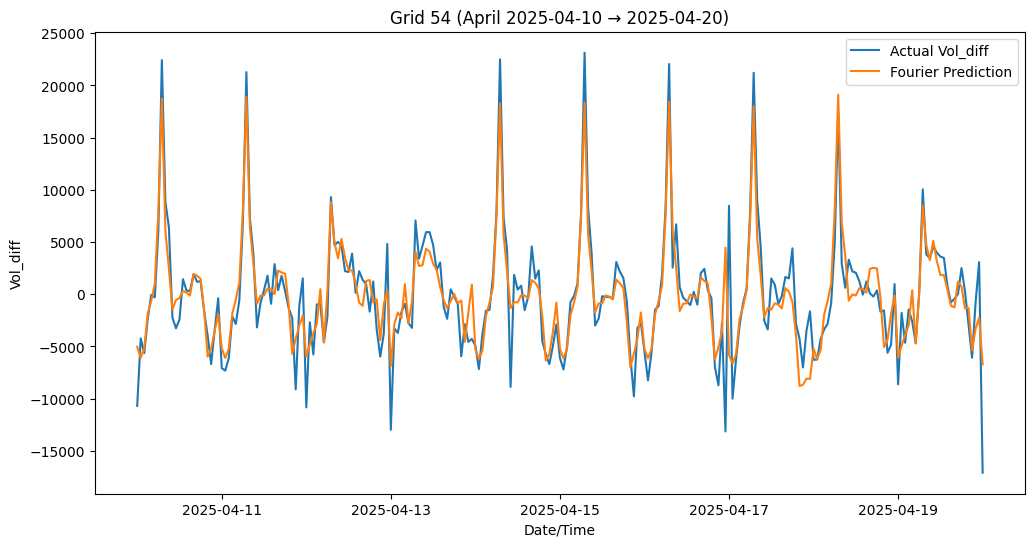

In [121]:
joined54= joined_eval[joined_eval["Grid_ID"] == 54]
# Define your date range
start_date = "2025-04-10"
end_date   = "2025-04-20"

# Filter April data for Grid 54
joined54_April = joined54[
    (joined54["End_Time"] >= pd.to_datetime(start_date)) &
    (joined54["End_Time"] <= pd.to_datetime(end_date))
]

# Plot actual vs predicted
plt.figure(figsize=(12,6))
plt.plot(joined54_April["End_Time"], joined54_April["Vol_diff"], label="Actual Vol_diff")
plt.plot(joined54_April["End_Time"], joined54_April["new_pred"], label="Fourier Prediction")
plt.xlabel("Date/Time")
plt.ylabel("Vol_diff")
plt.title(f"Grid 54 (April {start_date} → {end_date})")
plt.legend()
plt.show()    

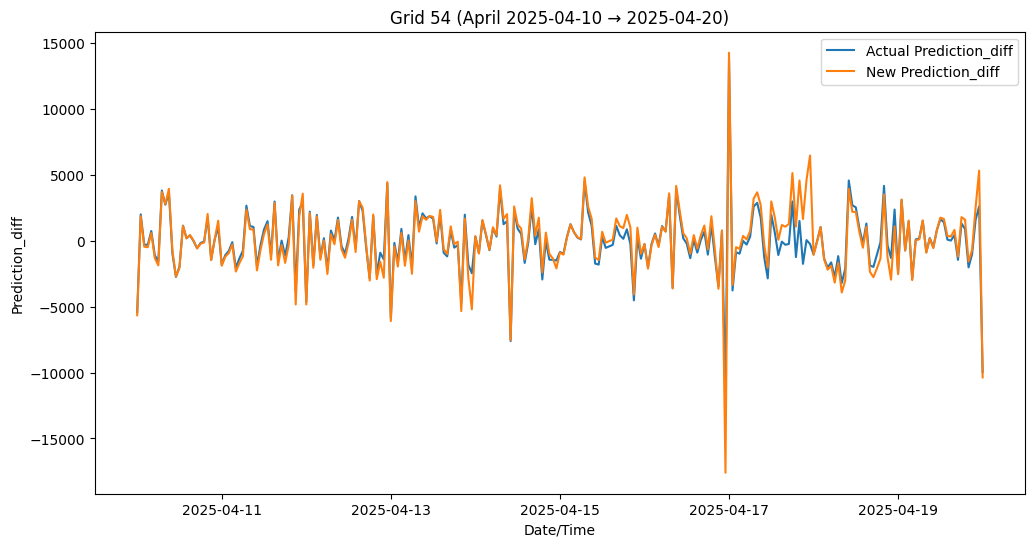

In [122]:

# Plot actual vs predicted
plt.figure(figsize=(12,6))
plt.plot(joined54_April["End_Time"], joined54_April["pred_diff"], label="Actual Prediction_diff")
plt.plot(joined54_April["End_Time"], joined54_April["new_pred_diff"], label="New Prediction_diff")

plt.xlabel("Date/Time")
plt.ylabel("Prediction_diff")
plt.title(f"Grid 54 (April {start_date} → {end_date})")
plt.legend()
plt.show() 

In [123]:
records = []

for group, df in joined_eval.groupby("Group"):
    for pred_col in ["y_pred", "new_pred"]:
        if pred_col not in df:
            continue  # skip if missing

        rmse = np.sqrt(mean_squared_error(df["Vol_diff"], df[pred_col]))
        r2 = r2_score(df["Vol_diff"], df[pred_col])

        records.append({
            "Group": group,
            "Prediction": pred_col,
            "RMSE": rmse,
            "R2": r2
        })

FitEval = pd.DataFrame(records)

In [124]:
FitEval

Group Prediction        RMSE        R2
0  Saturdays     y_pred  575.476994  0.784133
1  Saturdays   new_pred  634.777268  0.737352
2    Sundays     y_pred  674.488113  0.714609
3    Sundays   new_pred  737.893411  0.658431
4   Weekdays     y_pred  846.956720  0.771891
5   Weekdays   new_pred  941.489962  0.718129

In [125]:
records_may = []

for group, df in may_eval.groupby("Group"):
    for pred_col in ["y_pred", "new_pred"]:
        if pred_col not in df:
            continue  # skip if missing

        rmse = np.sqrt(mean_squared_error(df["Vol_diff"], df[pred_col]))
        r2 = r2_score(df["Vol_diff"], df[pred_col])

        records_may.append({
            "Group": group,
            "Prediction": pred_col,
            "RMSE": rmse,
            "R2": r2
        })

FitEvalMay = pd.DataFrame(records_may)




In [126]:
FitEvalMay

Group Prediction        RMSE        R2
0  Saturdays     y_pred  663.681277  0.746636
1  Saturdays   new_pred  747.248545  0.678815
2    Sundays     y_pred  582.557044  0.769974
3    Sundays   new_pred  637.733060  0.724337
4   Weekdays     y_pred  738.448823  0.826044
5   Weekdays   new_pred  809.385026  0.791017

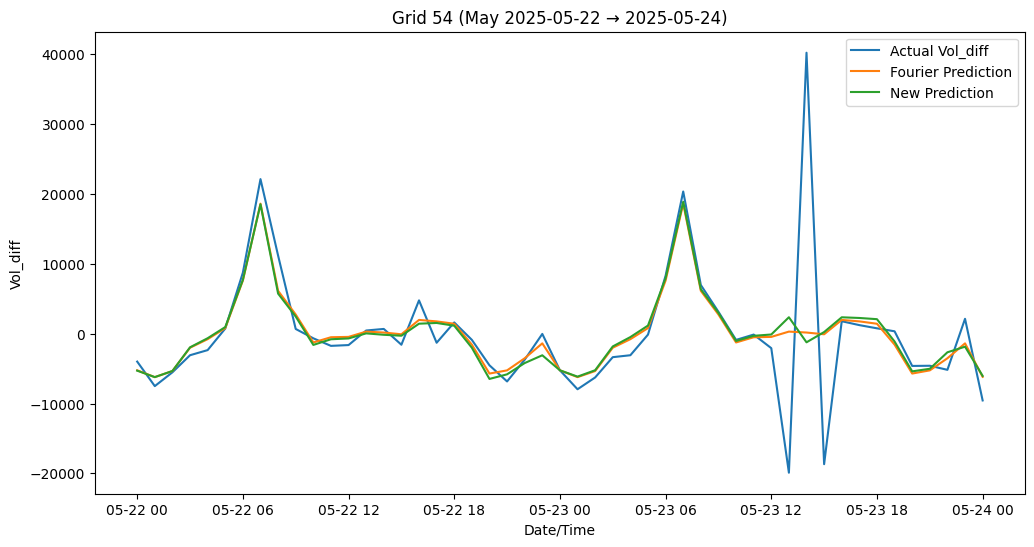

In [127]:
may54= may_eval[may_eval["Grid_ID"] == 54]
# Define your date range
start_date = "2025-05-22"
end_date   = "2025-05-24"

# Filter May data for Grid 54
may54_May = may54[
    (may54["End_Time"] >= pd.to_datetime(start_date)) &
    (may54["End_Time"] <= pd.to_datetime(end_date))
]

# Plot actual vs predicted
plt.figure(figsize=(12,6))
plt.plot(may54_May["End_Time"], may54_May["Vol_diff"], label="Actual Vol_diff")
plt.plot(may54_May["End_Time"], may54_May["y_pred"], label="Fourier Prediction")
plt.plot(may54_May["End_Time"], may54_May["new_pred"], label="New Prediction")
plt.xlabel("Date/Time")
plt.ylabel("Vol_diff")
plt.title(f"Grid 54 (May {start_date} → {end_date})")
plt.legend()
plt.show()    

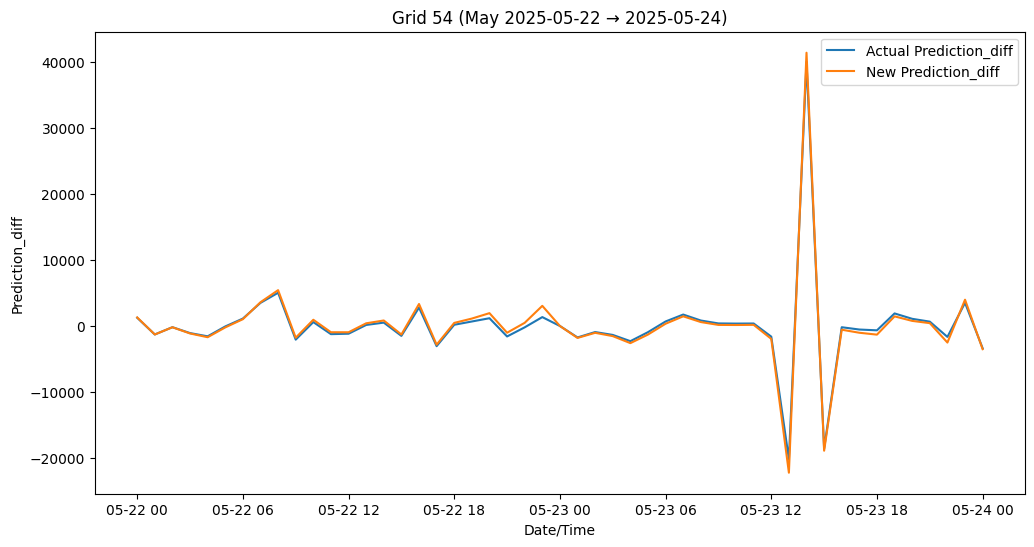

In [128]:
plt.figure(figsize=(12,6))
plt.plot(may54_May["End_Time"], may54_May["pred_diff"], label="Actual Prediction_diff")
plt.plot(may54_May["End_Time"], may54_May["new_pred_diff"], label="New Prediction_diff")

plt.xlabel("Date/Time")
plt.ylabel("Prediction_diff")
plt.title(f"Grid 54 (May {start_date} → {end_date})")
plt.legend()
plt.show() 

In [147]:
ar_params = {}

p = 3  # order of autoregression

for grid_id, grid_results in all_results.items():
    for label, res in grid_results.items():
        # Residuals from Fourier fit in training data
        df = joined_eval[
            (joined_eval["Grid_ID"] == grid_id) &
            (joined_eval["Group"] == label)
        ].copy()

        if df.empty:
            continue

        df["residual"] = df["Vol_diff"] - df["y_pred"]
        resid = df["residual"].dropna()

        if len(resid) < p + 1:
            continue

        # Fit AR(p)
        model = AutoReg(resid, lags=p, old_names=False).fit()

        ar_params[(grid_id, label)] = {
            "alpha": model.params[0],       # intercept
            "phis": model.params[1:].tolist()  # coefficients φ₁ ... φₚ
        }

C:\Users\smurph61\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\smurph61\AppData\Local\Temp\ipykernel_4080\2084896968.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "alpha": model.params[0],       # intercept
C:\Users\smurph61\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
C:\Users\smurph61\AppData\Local\Temp\ipy

In [148]:
def apply_arp_correction_global(df, ar_params):
    """
    Apply AR(p) correction to the entire dataframe.
    Uses params from ar_params[(grid_id, label)].
    Returns a copy with improved_pred column.
    """
    df = df.copy()
    df["improved_pred"] = np.nan

    for (grid_id, label), params in ar_params.items():
        alpha = params["alpha"]
        phis = params["phis"]  # list of φ₁ ... φₚ
        p = len(phis)

        mask = (df["Grid_ID"] == grid_id) & (df["Group"] == label)
        if not mask.any():
            continue

        sub = df.loc[mask].copy()
        sub = sub.sort_values("End_Time")  # ensure time order

        # Initialize lag buffer with zeros
        lagged_resids = [0.0] * p
        improved = []

        for _, row in sub.iterrows():
            # AR(p) update: r_t = α + Σ φ_i * r_{t-i}
            new_resid = alpha + sum(phi * lagged_resids[i] for i, phi in enumerate(phis))

            # Predicted Vol_diff = Fourier fit + AR correction
            improved.append(row["y_pred"] + new_resid)

            # Update lag buffer (push new_resid in, drop oldest)
            lagged_resids = [new_resid] + lagged_resids[:-1]

        df.loc[mask, "improved_pred"] = improved

    return df

In [149]:
may_eval = apply_arp_correction_global(may_eval, ar_params)


In [167]:
for group, df in may_eval.groupby("Group"):
    rmse_y = np.sqrt(mean_squared_error(df["Vol_diff"], df["y_pred"]))
    r2_y = r2_score(df["Vol_diff"], df["y_pred"])

    rmse_improved = np.sqrt(mean_squared_error(df["Vol_diff"], df["improved_pred"]))
    r2_improved = r2_score(df["Vol_diff"], df["improved_pred"])

    print(f"{group}:")
    print(f"  Results  -> RMSE={rmse_improved:.3f}, R²={r2_improved:.3f}")

Saturdays:
  Results  -> RMSE=663.648, R²=0.747
Sundays:
  Results  -> RMSE=582.563, R²=0.770
Weekdays:
  Results  -> RMSE=738.467, R²=0.826


In [156]:
joined_eval.head()

Grid_ID            End_Time  Sum_Volume  Vol_diff  weekday  hour     Group  \
0      3.0 2024-07-01 00:00:00       843.0       0.0        0     0  Weekdays   
1      3.0 2024-07-01 01:00:00       627.0    -216.0        0     1  Weekdays   
2      3.0 2024-07-01 02:00:00       340.0    -287.0        0     2  Weekdays   
3      3.0 2024-07-01 03:00:00       241.0     -99.0        0     3  Weekdays   
4      3.0 2024-07-01 04:00:00       183.0     -58.0        0     4  Weekdays   

       y_pred   pred_diff        date  cumsum_pred_diff    new_pred  \
0 -359.665712  359.665712  2024-07-01        359.665712 -374.052340   
1 -195.934247  -20.065753  2024-07-01        339.599959 -210.084245   
2 -149.019837 -137.980163  2024-07-01        201.619796 -157.785915   
3  -73.257535  -25.742465  2024-07-01        175.877331  -81.251959   
4   -2.949234  -55.050766  2024-07-01        120.826565   -8.702880   

   new_pred_diff  
0     374.052340  
1      -5.915755  
2    -129.214085  
3     -17.748041  
4     -49.297120

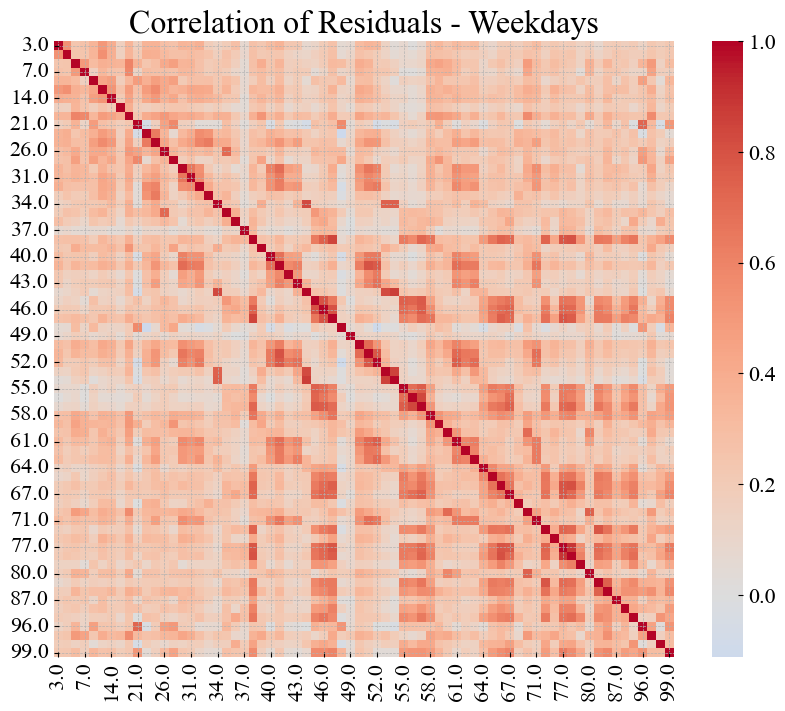

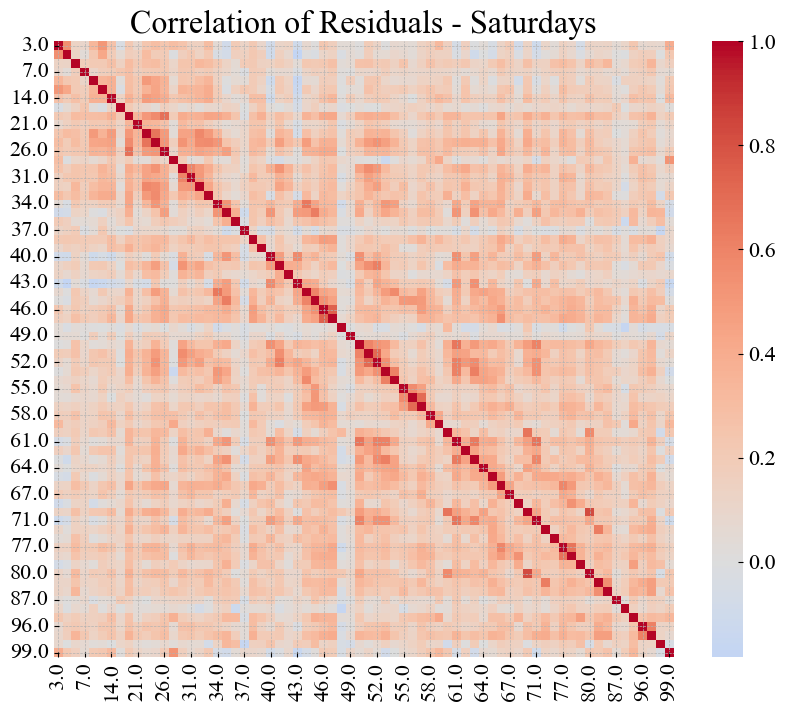

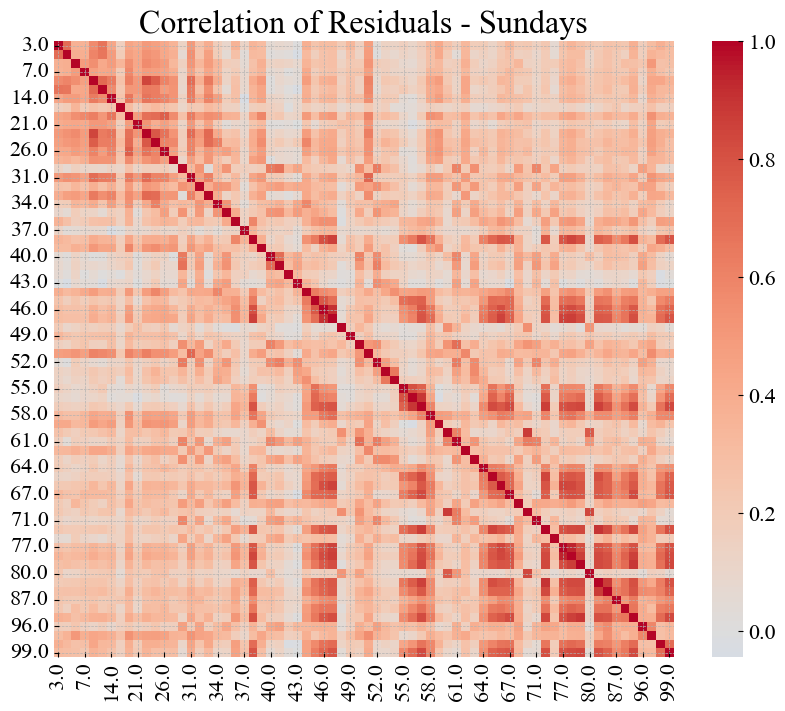

In [157]:
for group in ["Weekdays", "Saturdays", "Sundays"]:
    residuals = {}

    # Loop over grids
    for grid_id in all_results.keys():
        # Check if this grid has the group
        if group not in all_results[grid_id]:
            continue

        # Filter joined_eval for this grid and group
        df = joined_eval[(joined_eval["Grid_ID"] == grid_id) & 
                         (joined_eval["Group"] == group)].copy()
        if df.empty:
            continue

        # Compute residual
        df["residual"] = df["Vol_diff"] - df["y_pred"]

        # Align residuals by End_Time
        residuals[grid_id] = df.set_index("End_Time")["residual"]

    # Combine all grids into one DataFrame, indexed by timestamp
    df_resid = pd.concat(residuals, axis=1)  # columns = Grid_IDs

    # Drop timestamps with missing data in any grid
    df_resid = df_resid.dropna(how='any')

    # Correlation across Grid_IDs
    corr = df_resid.corr()

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, cmap="coolwarm", center=0)
    plt.title(f"Correlation of Residuals - {group}")
    plt.show()

In [165]:
may_eval.head()
may_eval["residuals"] = may_eval["Vol_diff"] - may_eval["improved_pred"]

In [168]:
may_eval.head()

Grid_ID            End_Time  Sum_Volume  Vol_diff  weekday  hour     Group  \
0      3.0 2025-05-01 00:00:00         626       0.0        3     0  Weekdays   
1      3.0 2025-05-01 01:00:00         377    -249.0        3     1  Weekdays   
2      3.0 2025-05-01 02:00:00         200    -177.0        3     2  Weekdays   
3      3.0 2025-05-01 03:00:00         148     -52.0        3     3  Weekdays   
4      3.0 2025-05-01 04:00:00         127     -21.0        3     4  Weekdays   

       y_pred   pred_diff        date  cumsum_pred_diff    new_pred  \
0 -359.665712  359.665712  2025-05-01        359.665712 -374.052340   
1 -195.934247  -53.065753  2025-05-01        306.599959 -208.709245   
2 -149.019837  -27.980163  2025-05-01        278.619796 -161.133742   
3  -73.257535   21.257535  2025-05-01        299.877331  -86.888323   
4   -2.949234  -18.050766  2025-05-01        281.826565  -16.369547   

   new_pred_diff  improved_pred    residues   residuals  
0     374.052340    -359.808281  359.808281  359.808281  
1     -40.290755    -196.079037  -52.920963  -52.920963  
2     -15.866258    -149.154644  -27.845356  -27.845356  
3      34.888323     -73.378130   21.378130   21.378130  
4      -4.630453      -3.070093  -17.929907  -17.929907

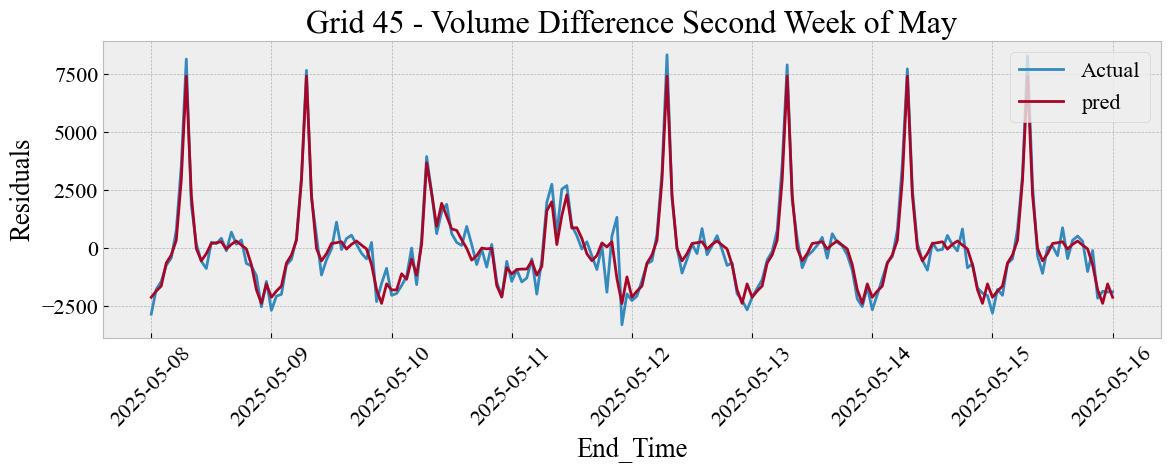

In [177]:


# Example inputs
grid_id = 45  # choose your grid
start_date = "2025-05-08"
end_date = "2025-05-16"

# Ensure End_Time is datetime
may_eval['End_Time'] = pd.to_datetime(may_eval['End_Time'])

# Filter for grid and date range
df_plot = may_eval[
    (may_eval["Grid_ID"] == grid_id) &
    (may_eval["End_Time"] >= start_date) &
    (may_eval["End_Time"] <= end_date)
].copy()

# Plot residuals
plt.figure(figsize=(12, 5))
plt.plot(df_plot["End_Time"], df_plot["Vol_diff"], label = "Actual")
plt.plot(df_plot["End_Time"],df_plot["improved_pred"],label = "pred")
plt.title(f"Grid {grid_id} - Volume Difference Second Week of May")
plt.xlabel("End_Time")
plt.ylabel("Residuals")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()